In [ ]:
#Python Version: 3.7.4
#PyTorch Version: 1.7.1

In [ ]:
import numpy as np 
import pandas as pd
import os
##Please copy and paste the path of the directory where the folder 'stat946winter2021' is present in the line below
BASE_PATH='/home/bharat/Desktop/STAT_946_Data_Challenge_1/stat946winter2021/'
train_dataset=pd.read_csv(os.path.join(BASE_PATH,'train_labels.csv'))
test_dataset=pd.read_csv(os.path.join(BASE_PATH,'test_labels.csv'))

In [ ]:
# Check the head of the train_dataset dataframe
train_dataset.head(3)

,File,Label
0,1329638562-58609.jpg,0
1,956062378-32202.jpg,0
2,118943055-21826.jpg,1


In [ ]:
# Check the head of the test_dataset dataframe
test_dataset.head(3)

,File
0,1002536285-58583.jpg
1,100738077-54097.jpg
2,100945025-10622.jpg


In [ ]:
#Plot Images to take a look at the X-Ray images
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(32, 32)) #Size of Figure
columns = 3 #Columns in fig
rows = 5 #Rows in Fig
#Total images = row* columns
for i in range(1,rows*columns+1):
    IMG_PATH=BASE_PATH+'train/'
    img=Image.open(os.path.join(IMG_PATH,train_dataset.iloc[i][0]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

<Figure size 3200x3200 with 15 Axes>

In [ ]:
#Import various libraries for CNN based image classification

from torchsummary import summary
import PIL
import sys
import torch
from time import time
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import torchvision.transforms as transforms

# I have used Efficientnet3 pre-trained model for the classification task
from efficientnet_pytorch import EfficientNet

#Data Loader

In [ ]:
#Define the Dataset class to pair images and labels

class Dataset(data.Dataset):
    def __init__(self,csv_path,images_path,transform=None):
        self.train_set=pd.read_csv(csv_path) #Read The CSV and create the dataframe
        self.train_path=images_path #Images Path
        self.transform=transform # Augmentation Transforms
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set.iloc[idx][0] 
        label=self.train_set.iloc[idx][1]
        img=Image.open(os.path.join(self.train_path,file_name)) #Loading Image
        if self.transform is not None:
            img=self.transform(img)
        return img,label

#Defining Transforms and Parameters for Training

In [ ]:
# Set the learning rate

learning_rate=1e-4

In [ ]:
# Prepare the dataset consisting of the training images and the corressponding labels

training_set_untransformed=Dataset(os.path.join(BASE_PATH,'train_labels.csv'),os.path.join(BASE_PATH,'train/'))
print(type(training_set_untransformed))


<class '__main__.Dataset'>


In [ ]:
# Define a transform operation that applies transformations to an image

transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip()],0.7),
		transforms.ToTensor()])


In [ ]:
#Create transformed images from the training dataset such that the minority class is upsampled and the 
#resulting classes are equal in number in the new set

new_created_images=[]
for j in range (len(training_set_untransformed)):
    if training_set_untransformed[j][1]==1:
        for k in range(8):
            transformed_image = transform_train(training_set_untransformed[j][0])
            new_created_images.append((transformed_image,1))
    else:
        transformed_image = transform_train(training_set_untransformed[j][0])
        new_created_images.append((transformed_image,0))

print(len(new_created_images))                                                                                   

26254


In [ ]:
# Split the new set into a training and validation dataset in the 80:20 ratio

train_size = int(0.8 * len(new_created_images))
validation_size = len(new_created_images) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(new_created_images, [train_size,validation_size])

In [ ]:
# Create batches of size 32 each from the training dataset

training_generator = data.DataLoader(train_dataset,shuffle=True,batch_size=32,pin_memory=True) 

In [ ]:
# Enable GPU computation

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


#Importing the model

In [ ]:
# Instantiate Efficientnet3 

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2)

Loaded pretrained weights for efficientnet-b3


In [ ]:
# Load the model to device

model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
# Display the summary of the model

print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 226, 226]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 40, 1, 1]             440
         I

In [ ]:
# Create a folder in the stat946winter2021 directory to save Weights

PATH_SAVE='./Weights/'
if(not os.path.exists(PATH_SAVE)):
    os.mkdir(PATH_SAVE)

In [ ]:
# Make crossentropyloss as the criterion, set a learning rate decay and use Adam or weight update

criterion = nn.CrossEntropyLoss()
lr_decay=0.99
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Create a class list

eye = torch.eye(2).to(device)
classes=[0,1]

In [ ]:
# Create lists to record accuracy and loss and set the number of epochs ( I got 11 as the optimal number of epochs)

history_accuracy=[]
history_loss=[]
epochs = 11

In [ ]:
# Train the model

for epoch in range(epochs):  
    running_loss = 0.0
    correct=0
    total=0
    class_correct = list(0. for _ in classes)
    class_total = list(0. for _ in classes)
    
    for i, data in enumerate(training_generator, 0):
        inputs, labels = data
        t0 = time()
        inputs, labels = inputs.to(device), labels.to(device)
        labels = eye[labels]
        optimizer.zero_grad()
        #torch.cuda.empty_cache()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        c = (predicted == labels.data).squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = float(correct) / float(total)
        
        history_accuracy.append(accuracy)
        history_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        for j in range(labels.size(0)):
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        
        running_loss += loss.item()
        
        print( "Epoch : ",epoch+1," Batch : ", i+1," Loss :  ",running_loss/(i+1)," Accuracy : ",accuracy,"Time ",round(time()-t0, 2),"s" )
    for k in range(len(classes)):
        if(class_total[k]!=0):
            print('Accuracy of %5s : %2d %%' % (classes[k], 100 * class_correct[k] / class_total[k]))
        
    print('[%d epoch] Accuracy of the network on the Training images: %d %%' % (epoch+1, 100 * correct / total))
    
    if epoch%10==0 or epoch==0:
        torch.save(model.state_dict(), os.path.join(PATH_SAVE,str(epoch+1)+'_'+str(accuracy)+'.pth'))
        
torch.save(model.state_dict(), os.path.join(PATH_SAVE,'Last_epoch'+str(accuracy)+'.pth'))

Epoch :  1  Batch :  1  Loss :   0.7175039052963257  Accuracy :  0.46875 Time  0.33 s
Epoch :  1  Batch :  2  Loss :   0.7257035076618195  Accuracy :  0.390625 Time  0.32 s
Epoch :  1  Batch :  3  Loss :   0.712292472521464  Accuracy :  0.40625 Time  0.32 s
Epoch :  1  Batch :  4  Loss :   0.6993562579154968  Accuracy :  0.453125 Time  0.33 s
Epoch :  1  Batch :  5  Loss :   0.6899105191230774  Accuracy :  0.49375 Time  0.32 s
Epoch :  1  Batch :  6  Loss :   0.6742877761522929  Accuracy :  0.5364583333333334 Time  0.32 s
Epoch :  1  Batch :  7  Loss :   0.6622494118554252  Accuracy :  0.5758928571428571 Time  0.32 s
Epoch :  1  Batch :  8  Loss :   0.654620811343193  Accuracy :  0.58984375 Time  0.32 s
Epoch :  1  Batch :  9  Loss :   0.6425103214051988  Accuracy :  0.6145833333333334 Time  0.32 s
Epoch :  1  Batch :  10  Loss :   0.6308210611343383  Accuracy :  0.640625 Time  0.33 s
Epoch :  1  Batch :  11  Loss :   0.6272809451276605  Accuracy :  0.6477272727272727 Time  0.32 s
Epoc

Epoch :  1  Batch :  87  Loss :   0.28805762743470315  Accuracy :  0.8803879310344828 Time  0.33 s
Epoch :  1  Batch :  88  Loss :   0.2877292586490512  Accuracy :  0.8803267045454546 Time  0.33 s
Epoch :  1  Batch :  89  Loss :   0.2872675967852721  Accuracy :  0.8809691011235955 Time  0.33 s
Epoch :  1  Batch :  90  Loss :   0.2863899322847525  Accuracy :  0.8809027777777778 Time  0.32 s
Epoch :  1  Batch :  91  Loss :   0.28490188005533845  Accuracy :  0.8815247252747253 Time  0.32 s
Epoch :  1  Batch :  92  Loss :   0.28243949329075607  Accuracy :  0.8828125 Time  0.32 s
Epoch :  1  Batch :  93  Loss :   0.28016382511905447  Accuracy :  0.8840725806451613 Time  0.32 s
Epoch :  1  Batch :  94  Loss :   0.2781330429493113  Accuracy :  0.8846409574468085 Time  0.32 s
Epoch :  1  Batch :  95  Loss :   0.2775402178889827  Accuracy :  0.8848684210526315 Time  0.33 s
Epoch :  1  Batch :  96  Loss :   0.2791753929729263  Accuracy :  0.8841145833333334 Time  0.32 s
Epoch :  1  Batch :  97  

Epoch :  1  Batch :  171  Loss :   0.21732820192493543  Accuracy :  0.9135599415204678 Time  0.32 s
Epoch :  1  Batch :  172  Loss :   0.2169038943274943  Accuracy :  0.9138808139534884 Time  0.32 s
Epoch :  1  Batch :  173  Loss :   0.21651254091519495  Accuracy :  0.9140173410404624 Time  0.32 s
Epoch :  1  Batch :  174  Loss :   0.21537824076782355  Accuracy :  0.9145114942528736 Time  0.32 s
Epoch :  1  Batch :  175  Loss :   0.21451494496847903  Accuracy :  0.915 Time  0.32 s
Epoch :  1  Batch :  176  Loss :   0.21369219367096032  Accuracy :  0.9154829545454546 Time  0.32 s
Epoch :  1  Batch :  177  Loss :   0.2134514555313998  Accuracy :  0.915430790960452 Time  0.32 s
Epoch :  1  Batch :  178  Loss :   0.2126241988826836  Accuracy :  0.9159058988764045 Time  0.32 s
Epoch :  1  Batch :  179  Loss :   0.21164026382956758  Accuracy :  0.9163756983240223 Time  0.32 s
Epoch :  1  Batch :  180  Loss :   0.21081801951966353  Accuracy :  0.9168402777777778 Time  0.32 s
Epoch :  1  Batch

Epoch :  1  Batch :  254  Loss :   0.17990713854005017  Accuracy :  0.9303641732283464 Time  0.32 s
Epoch :  1  Batch :  255  Loss :   0.17941635931823768  Accuracy :  0.9306372549019608 Time  0.32 s
Epoch :  1  Batch :  256  Loss :   0.17921545918215998  Accuracy :  0.9306640625 Time  0.32 s
Epoch :  1  Batch :  257  Loss :   0.17920799080847766  Accuracy :  0.9306906614785992 Time  0.32 s
Epoch :  1  Batch :  258  Loss :   0.17919462298353514  Accuracy :  0.9305959302325582 Time  0.32 s
Epoch :  1  Batch :  259  Loss :   0.17964357842464704  Accuracy :  0.9305019305019305 Time  0.32 s
Epoch :  1  Batch :  260  Loss :   0.17929491707338738  Accuracy :  0.9307692307692308 Time  0.32 s
Epoch :  1  Batch :  261  Loss :   0.17901357303291446  Accuracy :  0.9309147509578544 Time  0.32 s
Epoch :  1  Batch :  262  Loss :   0.17920424086788228  Accuracy :  0.9308206106870229 Time  0.32 s
Epoch :  1  Batch :  263  Loss :   0.17903445408938048  Accuracy :  0.9309648288973384 Time  0.32 s
Epoch 

Epoch :  1  Batch :  337  Loss :   0.1624824179679111  Accuracy :  0.9373145400593472 Time  0.32 s
Epoch :  1  Batch :  338  Loss :   0.1622065393689513  Accuracy :  0.9374075443786982 Time  0.32 s
Epoch :  1  Batch :  339  Loss :   0.16179024077853008  Accuracy :  0.9375921828908554 Time  0.32 s
Epoch :  1  Batch :  340  Loss :   0.16169555948992423  Accuracy :  0.9376838235294118 Time  0.32 s
Epoch :  1  Batch :  341  Loss :   0.16161323680960277  Accuracy :  0.9376832844574781 Time  0.32 s
Epoch :  1  Batch :  342  Loss :   0.16126889139904002  Accuracy :  0.9378654970760234 Time  0.32 s
Epoch :  1  Batch :  343  Loss :   0.1610292268308754  Accuracy :  0.9379555393586005 Time  0.32 s
Epoch :  1  Batch :  344  Loss :   0.16066442462778108  Accuracy :  0.9381359011627907 Time  0.32 s
Epoch :  1  Batch :  345  Loss :   0.16030472602587248  Accuracy :  0.9383152173913043 Time  0.32 s
Epoch :  1  Batch :  346  Loss :   0.16006258314453883  Accuracy :  0.9384031791907514 Time  0.32 s
Epo

Epoch :  1  Batch :  420  Loss :   0.1491206552412006  Accuracy :  0.9435267857142857 Time  0.32 s
Epoch :  1  Batch :  421  Loss :   0.14881495202530945  Accuracy :  0.9436609263657957 Time  0.32 s
Epoch :  1  Batch :  422  Loss :   0.14856770261460076  Accuracy :  0.9437203791469194 Time  0.32 s
Epoch :  1  Batch :  423  Loss :   0.14833751293757919  Accuracy :  0.9437795508274232 Time  0.32 s
Epoch :  1  Batch :  424  Loss :   0.1480634731157103  Accuracy :  0.9439121462264151 Time  0.32 s
Epoch :  1  Batch :  425  Loss :   0.14777894236366537  Accuracy :  0.9440441176470589 Time  0.32 s
Epoch :  1  Batch :  426  Loss :   0.1476873743277865  Accuracy :  0.9441021126760564 Time  0.32 s
Epoch :  1  Batch :  427  Loss :   0.1473959030112387  Accuracy :  0.9442330210772834 Time  0.32 s
Epoch :  1  Batch :  428  Loss :   0.14714772950326938  Accuracy :  0.9443633177570093 Time  0.32 s
Epoch :  1  Batch :  429  Loss :   0.1473386017431989  Accuracy :  0.9442016317016317 Time  0.32 s
Epoch

Epoch :  1  Batch :  503  Loss :   0.13831202345705826  Accuracy :  0.9484965208747514 Time  0.32 s
Epoch :  1  Batch :  504  Loss :   0.13819590384428876  Accuracy :  0.9485367063492064 Time  0.32 s
Epoch :  1  Batch :  505  Loss :   0.13797493953036494  Accuracy :  0.9486386138613861 Time  0.32 s
Epoch :  1  Batch :  506  Loss :   0.13783494307817853  Accuracy :  0.9486783596837944 Time  0.32 s
Epoch :  1  Batch :  507  Loss :   0.1376415111649877  Accuracy :  0.9487795857988166 Time  0.32 s
Epoch :  1  Batch :  508  Loss :   0.13745377048314733  Accuracy :  0.9488804133858267 Time  0.32 s
Epoch :  1  Batch :  509  Loss :   0.1372973690475456  Accuracy :  0.9489808447937131 Time  0.32 s
Epoch :  1  Batch :  510  Loss :   0.13721881177751163  Accuracy :  0.9490196078431372 Time  0.32 s
Epoch :  1  Batch :  511  Loss :   0.1370336555596988  Accuracy :  0.949119373776908 Time  0.32 s
Epoch :  1  Batch :  512  Loss :   0.13690099256018584  Accuracy :  0.94915771484375 Time  0.32 s
Epoch 

Epoch :  1  Batch :  586  Loss :   0.12907662770532885  Accuracy :  0.9525917235494881 Time  0.33 s
Epoch :  1  Batch :  587  Loss :   0.12899436985953272  Accuracy :  0.9525660136286201 Time  0.33 s
Epoch :  1  Batch :  588  Loss :   0.12882983757635946  Accuracy :  0.9526466836734694 Time  0.33 s
Epoch :  1  Batch :  589  Loss :   0.12868368751740997  Accuracy :  0.9527270797962648 Time  0.33 s
Epoch :  1  Batch :  590  Loss :   0.12851153444735555  Accuracy :  0.9528072033898305 Time  0.33 s
Epoch :  1  Batch :  591  Loss :   0.12834408113972462  Accuracy :  0.9528870558375635 Time  0.33 s
Epoch :  1  Batch :  592  Loss :   0.12816566555065456  Accuracy :  0.9529666385135135 Time  0.33 s
Epoch :  1  Batch :  593  Loss :   0.12809724407427603  Accuracy :  0.9529932546374368 Time  0.33 s
Epoch :  1  Batch :  594  Loss :   0.12839867403144362  Accuracy :  0.9529671717171717 Time  0.33 s
Epoch :  1  Batch :  595  Loss :   0.1282419801908819  Accuracy :  0.9530462184873949 Time  0.33 s
E

Epoch :  2  Batch :  12  Loss :   0.0413807425647974  Accuracy :  0.9895833333333334 Time  0.32 s
Epoch :  2  Batch :  13  Loss :   0.03953431102518852  Accuracy :  0.9903846153846154 Time  0.32 s
Epoch :  2  Batch :  14  Loss :   0.03729858435690403  Accuracy :  0.9910714285714286 Time  0.32 s
Epoch :  2  Batch :  15  Loss :   0.035633015694717565  Accuracy :  0.9916666666666667 Time  0.32 s
Epoch :  2  Batch :  16  Loss :   0.037225251842755824  Accuracy :  0.990234375 Time  0.32 s
Epoch :  2  Batch :  17  Loss :   0.035308303667561096  Accuracy :  0.9908088235294118 Time  0.32 s
Epoch :  2  Batch :  18  Loss :   0.03469093322443465  Accuracy :  0.9913194444444444 Time  0.32 s
Epoch :  2  Batch :  19  Loss :   0.03378656940338643  Accuracy :  0.9917763157894737 Time  0.32 s
Epoch :  2  Batch :  20  Loss :   0.032851710473187266  Accuracy :  0.9921875 Time  0.32 s
Epoch :  2  Batch :  21  Loss :   0.03242557684314393  Accuracy :  0.9925595238095238 Time  0.32 s
Epoch :  2  Batch :  22

Epoch :  2  Batch :  97  Loss :   0.04341105473967096  Accuracy :  0.9855025773195877 Time  0.32 s
Epoch :  2  Batch :  98  Loss :   0.04360478426976015  Accuracy :  0.9853316326530612 Time  0.32 s
Epoch :  2  Batch :  99  Loss :   0.04333607465348611  Accuracy :  0.985479797979798 Time  0.32 s
Epoch :  2  Batch :  100  Loss :   0.043267045733518895  Accuracy :  0.9853125 Time  0.32 s
Epoch :  2  Batch :  101  Loss :   0.04432652592382366  Accuracy :  0.9848391089108911 Time  0.32 s
Epoch :  2  Batch :  102  Loss :   0.044405915432007  Accuracy :  0.9849877450980392 Time  0.32 s
Epoch :  2  Batch :  103  Loss :   0.04516302302787171  Accuracy :  0.9848300970873787 Time  0.32 s
Epoch :  2  Batch :  104  Loss :   0.044979623200980805  Accuracy :  0.9849759615384616 Time  0.32 s
Epoch :  2  Batch :  105  Loss :   0.044604428258857555  Accuracy :  0.9851190476190477 Time  0.32 s
Epoch :  2  Batch :  106  Loss :   0.0442309721575101  Accuracy :  0.9852594339622641 Time  0.32 s
Epoch :  2  B

Epoch :  2  Batch :  180  Loss :   0.03922163535607979  Accuracy :  0.9875 Time  0.32 s
Epoch :  2  Batch :  181  Loss :   0.039155767056113365  Accuracy :  0.987396408839779 Time  0.32 s
Epoch :  2  Batch :  182  Loss :   0.03942478041722347  Accuracy :  0.9872939560439561 Time  0.32 s
Epoch :  2  Batch :  183  Loss :   0.039423947765802346  Accuracy :  0.9871926229508197 Time  0.32 s
Epoch :  2  Batch :  184  Loss :   0.03923409870122154  Accuracy :  0.9872622282608695 Time  0.32 s
Epoch :  2  Batch :  185  Loss :   0.03944255424336203  Accuracy :  0.9869932432432432 Time  0.32 s
Epoch :  2  Batch :  186  Loss :   0.03951730543712494  Accuracy :  0.9868951612903226 Time  0.32 s
Epoch :  2  Batch :  187  Loss :   0.0397595325397716  Accuracy :  0.986798128342246 Time  0.32 s
Epoch :  2  Batch :  188  Loss :   0.04079373978063504  Accuracy :  0.9867021276595744 Time  0.32 s
Epoch :  2  Batch :  189  Loss :   0.04121750917054082  Accuracy :  0.986441798941799 Time  0.32 s
Epoch :  2  Ba

Epoch :  2  Batch :  263  Loss :   0.03901859724224888  Accuracy :  0.9870484790874525 Time  0.32 s
Epoch :  2  Batch :  264  Loss :   0.03941413170435804  Accuracy :  0.9869791666666666 Time  0.32 s
Epoch :  2  Batch :  265  Loss :   0.039312792334811025  Accuracy :  0.9870283018867925 Time  0.32 s
Epoch :  2  Batch :  266  Loss :   0.03945063965314565  Accuracy :  0.9869595864661654 Time  0.32 s
Epoch :  2  Batch :  267  Loss :   0.039547865426391084  Accuracy :  0.9868913857677902 Time  0.32 s
Epoch :  2  Batch :  268  Loss :   0.04049221704689675  Accuracy :  0.9865904850746269 Time  0.32 s
Epoch :  2  Batch :  269  Loss :   0.04049566614296163  Accuracy :  0.9865241635687733 Time  0.32 s
Epoch :  2  Batch :  270  Loss :   0.040448137107995094  Accuracy :  0.986574074074074 Time  0.32 s
Epoch :  2  Batch :  271  Loss :   0.04033432404400705  Accuracy :  0.9866236162361623 Time  0.32 s
Epoch :  2  Batch :  272  Loss :   0.040192550866991306  Accuracy :  0.9866727941176471 Time  0.32

Epoch :  2  Batch :  345  Loss :   0.03957810105479228  Accuracy :  0.9872282608695652 Time  0.32 s
Epoch :  2  Batch :  346  Loss :   0.03954177642627377  Accuracy :  0.9872651734104047 Time  0.32 s
Epoch :  2  Batch :  347  Loss :   0.0399250596414806  Accuracy :  0.9872118155619597 Time  0.32 s
Epoch :  2  Batch :  348  Loss :   0.040364008182432264  Accuracy :  0.9870689655172413 Time  0.32 s
Epoch :  2  Batch :  349  Loss :   0.040269015896945315  Accuracy :  0.9871060171919771 Time  0.32 s
Epoch :  2  Batch :  350  Loss :   0.04031959307080667  Accuracy :  0.9870535714285714 Time  0.32 s
Epoch :  2  Batch :  351  Loss :   0.04050673717504203  Accuracy :  0.9870014245014245 Time  0.32 s
Epoch :  2  Batch :  352  Loss :   0.040451022162332345  Accuracy :  0.9870383522727273 Time  0.32 s
Epoch :  2  Batch :  353  Loss :   0.040391685953957396  Accuracy :  0.9870750708215298 Time  0.32 s
Epoch :  2  Batch :  354  Loss :   0.040446740854991926  Accuracy :  0.9870233050847458 Time  0.3

Epoch :  2  Batch :  428  Loss :   0.04014657311213299  Accuracy :  0.9872225467289719 Time  0.32 s
Epoch :  2  Batch :  429  Loss :   0.04006674096242271  Accuracy :  0.987252331002331 Time  0.32 s
Epoch :  2  Batch :  430  Loss :   0.04007806899080183  Accuracy :  0.9872093023255814 Time  0.32 s
Epoch :  2  Batch :  431  Loss :   0.040029307367634506  Accuracy :  0.9872389791183295 Time  0.32 s
Epoch :  2  Batch :  432  Loss :   0.039973186887908484  Accuracy :  0.9872685185185185 Time  0.32 s
Epoch :  2  Batch :  433  Loss :   0.03992082484283723  Accuracy :  0.9872979214780601 Time  0.33 s
Epoch :  2  Batch :  434  Loss :   0.03995744482569036  Accuracy :  0.9872551843317973 Time  0.32 s
Epoch :  2  Batch :  435  Loss :   0.03991582256035301  Accuracy :  0.9872844827586207 Time  0.32 s
Epoch :  2  Batch :  436  Loss :   0.03992492918602251  Accuracy :  0.9872419724770642 Time  0.32 s
Epoch :  2  Batch :  437  Loss :   0.03990698451745309  Accuracy :  0.9871996567505721 Time  0.32 s

Epoch :  2  Batch :  511  Loss :   0.03945129466381602  Accuracy :  0.9874633072407045 Time  0.32 s
Epoch :  2  Batch :  512  Loss :   0.03941669065852693  Accuracy :  0.98748779296875 Time  0.32 s
Epoch :  2  Batch :  513  Loss :   0.03937587729785918  Accuracy :  0.9875121832358674 Time  0.32 s
Epoch :  2  Batch :  514  Loss :   0.039330022347500326  Accuracy :  0.9875364785992218 Time  0.32 s
Epoch :  2  Batch :  515  Loss :   0.03929509381239203  Accuracy :  0.9875606796116505 Time  0.32 s
Epoch :  2  Batch :  516  Loss :   0.03925281902008091  Accuracy :  0.9875847868217055 Time  0.32 s
Epoch :  2  Batch :  517  Loss :   0.03927811726205397  Accuracy :  0.9876088007736944 Time  0.32 s
Epoch :  2  Batch :  518  Loss :   0.039210333492027946  Accuracy :  0.987632722007722 Time  0.32 s
Epoch :  2  Batch :  519  Loss :   0.03916541374600735  Accuracy :  0.9876565510597303 Time  0.32 s
Epoch :  2  Batch :  520  Loss :   0.03912198575025496  Accuracy :  0.9876802884615384 Time  0.32 s
E

Epoch :  2  Batch :  593  Loss :   0.03791634567140038  Accuracy :  0.9876159359190556 Time  0.32 s
Epoch :  2  Batch :  594  Loss :   0.03789479450929458  Accuracy :  0.9876367845117845 Time  0.32 s
Epoch :  2  Batch :  595  Loss :   0.03783939323121948  Accuracy :  0.9876575630252101 Time  0.32 s
Epoch :  2  Batch :  596  Loss :   0.037785452879237125  Accuracy :  0.9876782718120806 Time  0.32 s
Epoch :  2  Batch :  597  Loss :   0.037774864703937865  Accuracy :  0.9876989112227805 Time  0.32 s
Epoch :  2  Batch :  598  Loss :   0.037732230885231546  Accuracy :  0.9877194816053512 Time  0.32 s
Epoch :  2  Batch :  599  Loss :   0.03767341363651115  Accuracy :  0.9877399833055092 Time  0.32 s
Epoch :  2  Batch :  600  Loss :   0.03771042732017425  Accuracy :  0.9877083333333333 Time  0.32 s
Epoch :  2  Batch :  601  Loss :   0.03765502286890519  Accuracy :  0.9877287853577371 Time  0.32 s
Epoch :  2  Batch :  602  Loss :   0.037618613464253464  Accuracy :  0.987749169435216 Time  0.32

Epoch :  3  Batch :  18  Loss :   0.015059049267114865  Accuracy :  0.9965277777777778 Time  0.32 s
Epoch :  3  Batch :  19  Loss :   0.01430820664513464  Accuracy :  0.9967105263157895 Time  0.32 s
Epoch :  3  Batch :  20  Loss :   0.01364174605696462  Accuracy :  0.996875 Time  0.32 s
Epoch :  3  Batch :  21  Loss :   0.013331553560592943  Accuracy :  0.9970238095238095 Time  0.32 s
Epoch :  3  Batch :  22  Loss :   0.013634172749747946  Accuracy :  0.9971590909090909 Time  0.32 s
Epoch :  3  Batch :  23  Loss :   0.013191975820202219  Accuracy :  0.9972826086956522 Time  0.32 s
Epoch :  3  Batch :  24  Loss :   0.012697717364062555  Accuracy :  0.9973958333333334 Time  0.32 s
Epoch :  3  Batch :  25  Loss :   0.012447478375397622  Accuracy :  0.9975 Time  0.32 s
Epoch :  3  Batch :  26  Loss :   0.012432626175443428  Accuracy :  0.9975961538461539 Time  0.32 s
Epoch :  3  Batch :  27  Loss :   0.012001911458490347  Accuracy :  0.9976851851851852 Time  0.32 s
Epoch :  3  Batch :  28 

Epoch :  3  Batch :  102  Loss :   0.018424597914061307  Accuracy :  0.9941789215686274 Time  0.32 s
Epoch :  3  Batch :  103  Loss :   0.018830981284709992  Accuracy :  0.9939320388349514 Time  0.32 s
Epoch :  3  Batch :  104  Loss :   0.018765204835150283  Accuracy :  0.9939903846153846 Time  0.32 s
Epoch :  3  Batch :  105  Loss :   0.01865994323854379  Accuracy :  0.9940476190476191 Time  0.32 s
Epoch :  3  Batch :  106  Loss :   0.018555679414003982  Accuracy :  0.9941037735849056 Time  0.32 s
Epoch :  3  Batch :  107  Loss :   0.01841440801258486  Accuracy :  0.9941588785046729 Time  0.32 s
Epoch :  3  Batch :  108  Loss :   0.01885182670095539  Accuracy :  0.9939236111111112 Time  0.32 s
Epoch :  3  Batch :  109  Loss :   0.018824126238725362  Accuracy :  0.9939793577981652 Time  0.32 s
Epoch :  3  Batch :  110  Loss :   0.01885443259591491  Accuracy :  0.9940340909090909 Time  0.32 s
Epoch :  3  Batch :  111  Loss :   0.018765963404754026  Accuracy :  0.9940878378378378 Time  0

Epoch :  3  Batch :  184  Loss :   0.01863010979349897  Accuracy :  0.9942255434782609 Time  0.32 s
Epoch :  3  Batch :  185  Loss :   0.01854984644278129  Accuracy :  0.9942567567567567 Time  0.32 s
Epoch :  3  Batch :  186  Loss :   0.018564246542644137  Accuracy :  0.9942876344086021 Time  0.32 s
Epoch :  3  Batch :  187  Loss :   0.01860311426960659  Accuracy :  0.9943181818181818 Time  0.32 s
Epoch :  3  Batch :  188  Loss :   0.018527337223937873  Accuracy :  0.9943484042553191 Time  0.32 s
Epoch :  3  Batch :  189  Loss :   0.018601904364817692  Accuracy :  0.9942129629629629 Time  0.32 s
Epoch :  3  Batch :  190  Loss :   0.018510562784687958  Accuracy :  0.9942434210526315 Time  0.32 s
Epoch :  3  Batch :  191  Loss :   0.01842992345062548  Accuracy :  0.994273560209424 Time  0.32 s
Epoch :  3  Batch :  192  Loss :   0.01833612682094099  Accuracy :  0.9943033854166666 Time  0.32 s
Epoch :  3  Batch :  193  Loss :   0.0183924350458067  Accuracy :  0.9941709844559585 Time  0.32 

Epoch :  3  Batch :  266  Loss :   0.018468180243311014  Accuracy :  0.9943609022556391 Time  0.32 s
Epoch :  3  Batch :  267  Loss :   0.018509176283314378  Accuracy :  0.9943820224719101 Time  0.32 s
Epoch :  3  Batch :  268  Loss :   0.018482839771191965  Accuracy :  0.9944029850746269 Time  0.32 s
Epoch :  3  Batch :  269  Loss :   0.018434494552912267  Accuracy :  0.9944237918215614 Time  0.32 s
Epoch :  3  Batch :  270  Loss :   0.018380439230585816  Accuracy :  0.9944444444444445 Time  0.32 s
Epoch :  3  Batch :  271  Loss :   0.018478492519739206  Accuracy :  0.9943496309963099 Time  0.32 s
Epoch :  3  Batch :  272  Loss :   0.018423808318295737  Accuracy :  0.9943704044117647 Time  0.32 s
Epoch :  3  Batch :  273  Loss :   0.018361453161380447  Accuracy :  0.9943910256410257 Time  0.32 s
Epoch :  3  Batch :  274  Loss :   0.018299059437615048  Accuracy :  0.994411496350365 Time  0.32 s
Epoch :  3  Batch :  275  Loss :   0.018247546450319615  Accuracy :  0.9944318181818181 Time

Epoch :  3  Batch :  349  Loss :   0.019010947609035416  Accuracy :  0.9938216332378224 Time  0.32 s
Epoch :  3  Batch :  350  Loss :   0.01896295993730226  Accuracy :  0.9938392857142857 Time  0.32 s
Epoch :  3  Batch :  351  Loss :   0.01897412978725951  Accuracy :  0.9938568376068376 Time  0.32 s
Epoch :  3  Batch :  352  Loss :   0.018932385566007393  Accuracy :  0.9938742897727273 Time  0.32 s
Epoch :  3  Batch :  353  Loss :   0.018962069406723552  Accuracy :  0.9938031161473088 Time  0.32 s
Epoch :  3  Batch :  354  Loss :   0.01892552859589555  Accuracy :  0.9938206214689266 Time  0.32 s
Epoch :  3  Batch :  355  Loss :   0.01895523983337523  Accuracy :  0.9938380281690141 Time  0.32 s
Epoch :  3  Batch :  356  Loss :   0.018911508367912912  Accuracy :  0.9938553370786517 Time  0.32 s
Epoch :  3  Batch :  357  Loss :   0.01885912159413943  Accuracy :  0.9938725490196079 Time  0.32 s
Epoch :  3  Batch :  358  Loss :   0.018820678010540975  Accuracy :  0.9938896648044693 Time  0.

Epoch :  3  Batch :  431  Loss :   0.01935495185942509  Accuracy :  0.994054524361949 Time  0.32 s
Epoch :  3  Batch :  432  Loss :   0.019331824019125768  Accuracy :  0.9940682870370371 Time  0.32 s
Epoch :  3  Batch :  433  Loss :   0.019291660587410078  Accuracy :  0.9940819861431871 Time  0.32 s
Epoch :  3  Batch :  434  Loss :   0.019250203676454452  Accuracy :  0.9940956221198156 Time  0.32 s
Epoch :  3  Batch :  435  Loss :   0.0192354082989295  Accuracy :  0.9941091954022988 Time  0.32 s
Epoch :  3  Batch :  436  Loss :   0.01921636546423809  Accuracy :  0.9941227064220184 Time  0.32 s
Epoch :  3  Batch :  437  Loss :   0.01918866137366713  Accuracy :  0.9941361556064073 Time  0.32 s
Epoch :  3  Batch :  438  Loss :   0.01916242644356773  Accuracy :  0.9941495433789954 Time  0.32 s
Epoch :  3  Batch :  439  Loss :   0.019137534548684686  Accuracy :  0.9941628701594533 Time  0.32 s
Epoch :  3  Batch :  440  Loss :   0.01909907404998111  Accuracy :  0.9941761363636363 Time  0.32 

Epoch :  3  Batch :  513  Loss :   0.01874981920957519  Accuracy :  0.9942129629629629 Time  0.32 s
Epoch :  3  Batch :  514  Loss :   0.018742578573225307  Accuracy :  0.9942242217898832 Time  0.32 s
Epoch :  3  Batch :  515  Loss :   0.01870769788491318  Accuracy :  0.9942354368932039 Time  0.32 s
Epoch :  3  Batch :  516  Loss :   0.01867260292769512  Accuracy :  0.9942466085271318 Time  0.32 s
Epoch :  3  Batch :  517  Loss :   0.018640256629959766  Accuracy :  0.9942577369439072 Time  0.32 s
Epoch :  3  Batch :  518  Loss :   0.018608587812350273  Accuracy :  0.9942688223938224 Time  0.32 s
Epoch :  3  Batch :  519  Loss :   0.01857467983398602  Accuracy :  0.9942798651252408 Time  0.32 s
Epoch :  3  Batch :  520  Loss :   0.018602392801151908  Accuracy :  0.9942908653846154 Time  0.32 s
Epoch :  3  Batch :  521  Loss :   0.018572452438030178  Accuracy :  0.9943018234165067 Time  0.32 s
Epoch :  3  Batch :  522  Loss :   0.01854856772954559  Accuracy :  0.9943127394636015 Time  0.

Epoch :  3  Batch :  595  Loss :   0.019000823830695582  Accuracy :  0.9941701680672269 Time  0.32 s
Epoch :  3  Batch :  596  Loss :   0.019004860424569257  Accuracy :  0.9941799496644296 Time  0.32 s
Epoch :  3  Batch :  597  Loss :   0.018977738336625454  Accuracy :  0.9941896984924623 Time  0.32 s
Epoch :  3  Batch :  598  Loss :   0.019027780548409118  Accuracy :  0.9941471571906354 Time  0.32 s
Epoch :  3  Batch :  599  Loss :   0.01899752300871573  Accuracy :  0.9941569282136895 Time  0.32 s
Epoch :  3  Batch :  600  Loss :   0.018970364356039986  Accuracy :  0.9941666666666666 Time  0.32 s
Epoch :  3  Batch :  601  Loss :   0.018944425286566133  Accuracy :  0.9941763727121464 Time  0.32 s
Epoch :  3  Batch :  602  Loss :   0.019003478554710768  Accuracy :  0.9941341362126246 Time  0.32 s
Epoch :  3  Batch :  603  Loss :   0.018997963003374623  Accuracy :  0.994143864013267 Time  0.32 s
Epoch :  3  Batch :  604  Loss :   0.018970504235598647  Accuracy :  0.9941535596026491 Time 

Epoch :  4  Batch :  22  Loss :   0.004746043202678927  Accuracy :  1.0 Time  0.32 s
Epoch :  4  Batch :  23  Loss :   0.007377684435240277  Accuracy :  0.998641304347826 Time  0.32 s
Epoch :  4  Batch :  24  Loss :   0.007296649268634307  Accuracy :  0.9986979166666666 Time  0.32 s
Epoch :  4  Batch :  25  Loss :   0.007156692403368652  Accuracy :  0.99875 Time  0.32 s
Epoch :  4  Batch :  26  Loss :   0.0069165690757262595  Accuracy :  0.9987980769230769 Time  0.32 s
Epoch :  4  Batch :  27  Loss :   0.006760832426759104  Accuracy :  0.9988425925925926 Time  0.32 s
Epoch :  4  Batch :  28  Loss :   0.0065754318493418396  Accuracy :  0.9988839285714286 Time  0.32 s
Epoch :  4  Batch :  29  Loss :   0.006367503599151327  Accuracy :  0.9989224137931034 Time  0.32 s
Epoch :  4  Batch :  30  Loss :   0.006166103210610648  Accuracy :  0.9989583333333333 Time  0.32 s
Epoch :  4  Batch :  31  Loss :   0.006129058926636653  Accuracy :  0.998991935483871 Time  0.32 s
Epoch :  4  Batch :  32  L

Epoch :  4  Batch :  105  Loss :   0.011057115368090481  Accuracy :  0.9958333333333333 Time  0.32 s
Epoch :  4  Batch :  106  Loss :   0.011034033792521717  Accuracy :  0.995872641509434 Time  0.32 s
Epoch :  4  Batch :  107  Loss :   0.01093703159593507  Accuracy :  0.9959112149532711 Time  0.32 s
Epoch :  4  Batch :  108  Loss :   0.010840535493453327  Accuracy :  0.9959490740740741 Time  0.32 s
Epoch :  4  Batch :  109  Loss :   0.01079180029006205  Accuracy :  0.9959862385321101 Time  0.32 s
Epoch :  4  Batch :  110  Loss :   0.010718711918294006  Accuracy :  0.9960227272727272 Time  0.32 s
Epoch :  4  Batch :  111  Loss :   0.010631661750701349  Accuracy :  0.9960585585585585 Time  0.32 s
Epoch :  4  Batch :  112  Loss :   0.01055718086484246  Accuracy :  0.99609375 Time  0.32 s
Epoch :  4  Batch :  113  Loss :   0.011323465442076837  Accuracy :  0.9958517699115044 Time  0.32 s
Epoch :  4  Batch :  114  Loss :   0.01123518501423716  Accuracy :  0.9958881578947368 Time  0.32 s
Epo

Epoch :  4  Batch :  187  Loss :   0.012617783304935765  Accuracy :  0.995822192513369 Time  0.32 s
Epoch :  4  Batch :  188  Loss :   0.01256061752691823  Accuracy :  0.995844414893617 Time  0.32 s
Epoch :  4  Batch :  189  Loss :   0.012576725557135423  Accuracy :  0.9958664021164021 Time  0.32 s
Epoch :  4  Batch :  190  Loss :   0.012536385470593815  Accuracy :  0.9958881578947368 Time  0.32 s
Epoch :  4  Batch :  191  Loss :   0.012480076596476698  Accuracy :  0.9959096858638743 Time  0.32 s
Epoch :  4  Batch :  192  Loss :   0.01259260310227243  Accuracy :  0.9957682291666666 Time  0.32 s
Epoch :  4  Batch :  193  Loss :   0.012542752339368942  Accuracy :  0.9957901554404145 Time  0.32 s
Epoch :  4  Batch :  194  Loss :   0.012488251439395923  Accuracy :  0.9958118556701031 Time  0.32 s
Epoch :  4  Batch :  195  Loss :   0.012455010999409028  Accuracy :  0.9958333333333333 Time  0.32 s
Epoch :  4  Batch :  196  Loss :   0.01239455721870585  Accuracy :  0.9958545918367347 Time  0.

Epoch :  4  Batch :  269  Loss :   0.012060219913975446  Accuracy :  0.9960501858736059 Time  0.32 s
Epoch :  4  Batch :  270  Loss :   0.012017702985987718  Accuracy :  0.9960648148148148 Time  0.32 s
Epoch :  4  Batch :  271  Loss :   0.012003453852579482  Accuracy :  0.996079335793358 Time  0.32 s
Epoch :  4  Batch :  272  Loss :   0.01196199342317574  Accuracy :  0.99609375 Time  0.32 s
Epoch :  4  Batch :  273  Loss :   0.01196509273630819  Accuracy :  0.9961080586080586 Time  0.32 s
Epoch :  4  Batch :  274  Loss :   0.012276317666721404  Accuracy :  0.9960082116788321 Time  0.32 s
Epoch :  4  Batch :  275  Loss :   0.012275178409538718  Accuracy :  0.9960227272727272 Time  0.32 s
Epoch :  4  Batch :  276  Loss :   0.01231726926856198  Accuracy :  0.9960371376811594 Time  0.32 s
Epoch :  4  Batch :  277  Loss :   0.012298356942491104  Accuracy :  0.9960514440433214 Time  0.32 s
Epoch :  4  Batch :  278  Loss :   0.01234028827335521  Accuracy :  0.9960656474820144 Time  0.32 s
Epo

Epoch :  4  Batch :  351  Loss :   0.012162040494707167  Accuracy :  0.9960826210826211 Time  0.32 s
Epoch :  4  Batch :  352  Loss :   0.012129497668876287  Accuracy :  0.99609375 Time  0.32 s
Epoch :  4  Batch :  353  Loss :   0.012229449948914386  Accuracy :  0.9960162889518414 Time  0.33 s
Epoch :  4  Batch :  354  Loss :   0.01261229376065636  Accuracy :  0.9959392655367232 Time  0.32 s
Epoch :  4  Batch :  355  Loss :   0.012770964317591484  Accuracy :  0.995862676056338 Time  0.32 s
Epoch :  4  Batch :  356  Loss :   0.012993560190449662  Accuracy :  0.9957865168539326 Time  0.32 s
Epoch :  4  Batch :  357  Loss :   0.012959378740678268  Accuracy :  0.9957983193277311 Time  0.32 s
Epoch :  4  Batch :  358  Loss :   0.012928520674162752  Accuracy :  0.9958100558659218 Time  0.32 s
Epoch :  4  Batch :  359  Loss :   0.013205387991633604  Accuracy :  0.9957346796657381 Time  0.32 s
Epoch :  4  Batch :  360  Loss :   0.01318918461669859  Accuracy :  0.9957465277777777 Time  0.32 s
E

Epoch :  4  Batch :  433  Loss :   0.01344458764645909  Accuracy :  0.995453233256351 Time  0.32 s
Epoch :  4  Batch :  434  Loss :   0.013416963941460887  Accuracy :  0.9954637096774194 Time  0.32 s
Epoch :  4  Batch :  435  Loss :   0.013393247130552063  Accuracy :  0.9954741379310345 Time  0.32 s
Epoch :  4  Batch :  436  Loss :   0.013426878402851549  Accuracy :  0.9954128440366973 Time  0.32 s
Epoch :  4  Batch :  437  Loss :   0.013408097318977075  Accuracy :  0.9954233409610984 Time  0.32 s
Epoch :  4  Batch :  438  Loss :   0.01338061136195733  Accuracy :  0.9954337899543378 Time  0.32 s
Epoch :  4  Batch :  439  Loss :   0.013376047081443769  Accuracy :  0.9954441913439636 Time  0.32 s
Epoch :  4  Batch :  440  Loss :   0.013363278387135902  Accuracy :  0.9954545454545455 Time  0.32 s
Epoch :  4  Batch :  441  Loss :   0.013355229876517667  Accuracy :  0.9954648526077098 Time  0.32 s
Epoch :  4  Batch :  442  Loss :   0.013331132210134036  Accuracy :  0.995475113122172 Time  0

Epoch :  4  Batch :  515  Loss :   0.012690167466792543  Accuracy :  0.9956917475728155 Time  0.32 s
Epoch :  4  Batch :  516  Loss :   0.012677567854447007  Accuracy :  0.9957000968992248 Time  0.32 s
Epoch :  4  Batch :  517  Loss :   0.012706459716548822  Accuracy :  0.995708413926499 Time  0.32 s
Epoch :  4  Batch :  518  Loss :   0.01269406760087994  Accuracy :  0.9957166988416989 Time  0.32 s
Epoch :  4  Batch :  519  Loss :   0.012676839539565037  Accuracy :  0.9957249518304432 Time  0.32 s
Epoch :  4  Batch :  520  Loss :   0.012866228432519096  Accuracy :  0.9956730769230769 Time  0.32 s
Epoch :  4  Batch :  521  Loss :   0.012842130724191471  Accuracy :  0.9956813819577736 Time  0.32 s
Epoch :  4  Batch :  522  Loss :   0.012820919934414933  Accuracy :  0.9956896551724138 Time  0.32 s
Epoch :  4  Batch :  523  Loss :   0.012869122822582955  Accuracy :  0.9956381453154876 Time  0.32 s
Epoch :  4  Batch :  524  Loss :   0.01285599973318368  Accuracy :  0.9956464694656488 Time  

Epoch :  4  Batch :  597  Loss :   0.012642070748950747  Accuracy :  0.9958123953098827 Time  0.32 s
Epoch :  4  Batch :  598  Loss :   0.012622301170377251  Accuracy :  0.995819397993311 Time  0.32 s
Epoch :  4  Batch :  599  Loss :   0.012627708910172114  Accuracy :  0.9958263772954925 Time  0.32 s
Epoch :  4  Batch :  600  Loss :   0.012617444064144365  Accuracy :  0.9958333333333333 Time  0.32 s
Epoch :  4  Batch :  601  Loss :   0.0125978765250926  Accuracy :  0.9958402662229617 Time  0.32 s
Epoch :  4  Batch :  602  Loss :   0.012577540639842687  Accuracy :  0.9958471760797342 Time  0.32 s
Epoch :  4  Batch :  603  Loss :   0.012559794789671933  Accuracy :  0.9958540630182421 Time  0.32 s
Epoch :  4  Batch :  604  Loss :   0.012583026312168894  Accuracy :  0.9958091887417219 Time  0.32 s
Epoch :  4  Batch :  605  Loss :   0.012601563680542043  Accuracy :  0.9957644628099174 Time  0.32 s
Epoch :  4  Batch :  606  Loss :   0.012638665294367522  Accuracy :  0.9957198844884488 Time  

Epoch :  5  Batch :  23  Loss :   0.015308593442845766  Accuracy :  0.9959239130434783 Time  0.32 s
Epoch :  5  Batch :  24  Loss :   0.014838872479837542  Accuracy :  0.99609375 Time  0.32 s
Epoch :  5  Batch :  25  Loss :   0.014290018135216086  Accuracy :  0.99625 Time  0.32 s
Epoch :  5  Batch :  26  Loss :   0.014100165623508824  Accuracy :  0.9963942307692307 Time  0.32 s
Epoch :  5  Batch :  27  Loss :   0.014016785604999986  Accuracy :  0.9965277777777778 Time  0.32 s
Epoch :  5  Batch :  28  Loss :   0.013555600172756905  Accuracy :  0.9966517857142857 Time  0.32 s
Epoch :  5  Batch :  29  Loss :   0.013116256889871097  Accuracy :  0.9967672413793104 Time  0.32 s
Epoch :  5  Batch :  30  Loss :   0.012714725858919943  Accuracy :  0.996875 Time  0.32 s
Epoch :  5  Batch :  31  Loss :   0.012327331749181594  Accuracy :  0.9969758064516129 Time  0.32 s
Epoch :  5  Batch :  32  Loss :   0.011986547699052608  Accuracy :  0.9970703125 Time  0.32 s
Epoch :  5  Batch :  33  Loss :   0

Epoch :  5  Batch :  107  Loss :   0.011411472230907051  Accuracy :  0.9962032710280374 Time  0.32 s
Epoch :  5  Batch :  108  Loss :   0.011407115003681544  Accuracy :  0.9962384259259259 Time  0.32 s
Epoch :  5  Batch :  109  Loss :   0.012293310706325328  Accuracy :  0.9956995412844036 Time  0.32 s
Epoch :  5  Batch :  110  Loss :   0.012182800320971927  Accuracy :  0.9957386363636364 Time  0.32 s
Epoch :  5  Batch :  111  Loss :   0.012094322681691297  Accuracy :  0.995777027027027 Time  0.32 s
Epoch :  5  Batch :  112  Loss :   0.012447971307535357  Accuracy :  0.9955357142857143 Time  0.32 s
Epoch :  5  Batch :  113  Loss :   0.012347183517382307  Accuracy :  0.995575221238938 Time  0.32 s
Epoch :  5  Batch :  114  Loss :   0.012246806807142045  Accuracy :  0.9956140350877193 Time  0.32 s
Epoch :  5  Batch :  115  Loss :   0.01214292244024008  Accuracy :  0.9956521739130435 Time  0.32 s
Epoch :  5  Batch :  116  Loss :   0.012041691520074704  Accuracy :  0.9956896551724138 Time  

Epoch :  5  Batch :  189  Loss :   0.012033561870031349  Accuracy :  0.9955357142857143 Time  0.32 s
Epoch :  5  Batch :  190  Loss :   0.012118424871847597  Accuracy :  0.9955592105263158 Time  0.32 s
Epoch :  5  Batch :  191  Loss :   0.012059271850861506  Accuracy :  0.9955824607329843 Time  0.32 s
Epoch :  5  Batch :  192  Loss :   0.011997246417043547  Accuracy :  0.99560546875 Time  0.32 s
Epoch :  5  Batch :  193  Loss :   0.011947207636148018  Accuracy :  0.9956282383419689 Time  0.32 s
Epoch :  5  Batch :  194  Loss :   0.011922485995155606  Accuracy :  0.9956507731958762 Time  0.32 s
Epoch :  5  Batch :  195  Loss :   0.011952579349357013  Accuracy :  0.9956730769230769 Time  0.32 s
Epoch :  5  Batch :  196  Loss :   0.011895333824956038  Accuracy :  0.9956951530612245 Time  0.32 s
Epoch :  5  Batch :  197  Loss :   0.011854465564666789  Accuracy :  0.9957170050761421 Time  0.32 s
Epoch :  5  Batch :  198  Loss :   0.011799537568650622  Accuracy :  0.9957386363636364 Time  0.

Epoch :  5  Batch :  271  Loss :   0.01062006217699823  Accuracy :  0.996309963099631 Time  0.32 s
Epoch :  5  Batch :  272  Loss :   0.01058349473878613  Accuracy :  0.9963235294117647 Time  0.32 s
Epoch :  5  Batch :  273  Loss :   0.010549810050888682  Accuracy :  0.9963369963369964 Time  0.32 s
Epoch :  5  Batch :  274  Loss :   0.010513052327572898  Accuracy :  0.9963503649635036 Time  0.32 s
Epoch :  5  Batch :  275  Loss :   0.010475114937137485  Accuracy :  0.9963636363636363 Time  0.32 s
Epoch :  5  Batch :  276  Loss :   0.010443568189716841  Accuracy :  0.9963768115942029 Time  0.32 s
Epoch :  5  Batch :  277  Loss :   0.010405921721943387  Accuracy :  0.9963898916967509 Time  0.32 s
Epoch :  5  Batch :  278  Loss :   0.010368804708004907  Accuracy :  0.9964028776978417 Time  0.32 s
Epoch :  5  Batch :  279  Loss :   0.010339190762198578  Accuracy :  0.996415770609319 Time  0.32 s
Epoch :  5  Batch :  280  Loss :   0.010344117779433353  Accuracy :  0.9964285714285714 Time  0

Epoch :  5  Batch :  353  Loss :   0.010676415293207378  Accuracy :  0.9964589235127479 Time  0.32 s
Epoch :  5  Batch :  354  Loss :   0.010647337078052706  Accuracy :  0.9964689265536724 Time  0.32 s
Epoch :  5  Batch :  355  Loss :   0.011719526554511951  Accuracy :  0.9962147887323943 Time  0.32 s
Epoch :  5  Batch :  356  Loss :   0.011687928205298775  Accuracy :  0.9962254213483146 Time  0.32 s
Epoch :  5  Batch :  357  Loss :   0.011657387364718668  Accuracy :  0.9962359943977591 Time  0.32 s
Epoch :  5  Batch :  358  Loss :   0.011627997537268724  Accuracy :  0.9962465083798883 Time  0.32 s
Epoch :  5  Batch :  359  Loss :   0.011597605366566255  Accuracy :  0.9962569637883009 Time  0.32 s
Epoch :  5  Batch :  360  Loss :   0.011568588303190255  Accuracy :  0.9962673611111111 Time  0.32 s
Epoch :  5  Batch :  361  Loss :   0.011555988052829267  Accuracy :  0.996277700831025 Time  0.32 s
Epoch :  5  Batch :  362  Loss :   0.011566098982885348  Accuracy :  0.9962879834254144 Time

Epoch :  5  Batch :  435  Loss :   0.012054181477739396  Accuracy :  0.9960488505747126 Time  0.32 s
Epoch :  5  Batch :  436  Loss :   0.012028315205456355  Accuracy :  0.9960579128440367 Time  0.32 s
Epoch :  5  Batch :  437  Loss :   0.012001743408218234  Accuracy :  0.9960669336384439 Time  0.32 s
Epoch :  5  Batch :  438  Loss :   0.011978966304279528  Accuracy :  0.9960759132420092 Time  0.32 s
Epoch :  5  Batch :  439  Loss :   0.011963716557682073  Accuracy :  0.9960848519362187 Time  0.32 s
Epoch :  5  Batch :  440  Loss :   0.012086642487156496  Accuracy :  0.9960227272727272 Time  0.32 s
Epoch :  5  Batch :  441  Loss :   0.012061645991884699  Accuracy :  0.996031746031746 Time  0.33 s
Epoch :  5  Batch :  442  Loss :   0.012059554423078999  Accuracy :  0.9960407239819005 Time  0.34 s
Epoch :  5  Batch :  443  Loss :   0.012072598392589404  Accuracy :  0.9960496613995485 Time  0.33 s
Epoch :  5  Batch :  444  Loss :   0.012076974558186595  Accuracy :  0.9960585585585585 Time

Epoch :  5  Batch :  517  Loss :   0.012227478246937498  Accuracy :  0.9960106382978723 Time  0.32 s
Epoch :  5  Batch :  518  Loss :   0.012208243592278843  Accuracy :  0.9960183397683398 Time  0.32 s
Epoch :  5  Batch :  519  Loss :   0.012223608854045304  Accuracy :  0.9960260115606936 Time  0.32 s
Epoch :  5  Batch :  520  Loss :   0.01220189258901183  Accuracy :  0.9960336538461538 Time  0.32 s
Epoch :  5  Batch :  521  Loss :   0.012182255092740815  Accuracy :  0.9960412667946257 Time  0.32 s
Epoch :  5  Batch :  522  Loss :   0.012161816435729347  Accuracy :  0.9960488505747126 Time  0.32 s
Epoch :  5  Batch :  523  Loss :   0.012139389342685181  Accuracy :  0.9960564053537285 Time  0.32 s
Epoch :  5  Batch :  524  Loss :   0.012121339793442988  Accuracy :  0.9960639312977099 Time  0.32 s
Epoch :  5  Batch :  525  Loss :   0.01210541402929396  Accuracy :  0.9960714285714286 Time  0.32 s
Epoch :  5  Batch :  526  Loss :   0.012084306383804469  Accuracy :  0.996078897338403 Time  

Epoch :  5  Batch :  599  Loss :   0.011271997005047078  Accuracy :  0.9963480801335559 Time  0.32 s
Epoch :  5  Batch :  600  Loss :   0.01129196889072773  Accuracy :  0.9963541666666667 Time  0.32 s
Epoch :  5  Batch :  601  Loss :   0.01127320481990896  Accuracy :  0.9963602329450915 Time  0.32 s
Epoch :  5  Batch :  602  Loss :   0.011254569430794403  Accuracy :  0.9963662790697675 Time  0.32 s
Epoch :  5  Batch :  603  Loss :   0.011236573023653088  Accuracy :  0.9963723051409619 Time  0.32 s
Epoch :  5  Batch :  604  Loss :   0.011221635096937209  Accuracy :  0.9963783112582781 Time  0.32 s
Epoch :  5  Batch :  605  Loss :   0.011283199018217895  Accuracy :  0.9963326446280992 Time  0.32 s
Epoch :  5  Batch :  606  Loss :   0.011264980608037076  Accuracy :  0.996338696369637 Time  0.32 s
Epoch :  5  Batch :  607  Loss :   0.011326895005177697  Accuracy :  0.9962932454695222 Time  0.32 s
Epoch :  5  Batch :  608  Loss :   0.011308354211612488  Accuracy :  0.9962993421052632 Time  

Epoch :  6  Batch :  26  Loss :   0.003329889932781673  Accuracy :  0.9987980769230769 Time  0.32 s
Epoch :  6  Batch :  27  Loss :   0.003211131081722366  Accuracy :  0.9988425925925926 Time  0.32 s
Epoch :  6  Batch :  28  Loss :   0.003105869274025151  Accuracy :  0.9988839285714286 Time  0.32 s
Epoch :  6  Batch :  29  Loss :   0.0031214387959937148  Accuracy :  0.9989224137931034 Time  0.32 s
Epoch :  6  Batch :  30  Loss :   0.0030318654195677177  Accuracy :  0.9989583333333333 Time  0.32 s
Epoch :  6  Batch :  31  Loss :   0.0029530800093198195  Accuracy :  0.998991935483871 Time  0.32 s
Epoch :  6  Batch :  32  Loss :   0.0028636690826715494  Accuracy :  0.9990234375 Time  0.32 s
Epoch :  6  Batch :  33  Loss :   0.0028474391283728464  Accuracy :  0.9990530303030303 Time  0.32 s
Epoch :  6  Batch :  34  Loss :   0.0028025256080368042  Accuracy :  0.9990808823529411 Time  0.32 s
Epoch :  6  Batch :  35  Loss :   0.0027260644565103576  Accuracy :  0.9991071428571429 Time  0.32 s


Epoch :  6  Batch :  109  Loss :   0.010867432296119093  Accuracy :  0.9971330275229358 Time  0.35 s
Epoch :  6  Batch :  110  Loss :   0.01085053364632503  Accuracy :  0.9971590909090909 Time  0.33 s
Epoch :  6  Batch :  111  Loss :   0.010766593116542182  Accuracy :  0.9971846846846847 Time  0.35 s
Epoch :  6  Batch :  112  Loss :   0.010713939881497936  Accuracy :  0.9972098214285714 Time  0.36 s
Epoch :  6  Batch :  113  Loss :   0.010626420370056872  Accuracy :  0.9972345132743363 Time  0.32 s
Epoch :  6  Batch :  114  Loss :   0.01054269925391469  Accuracy :  0.9972587719298246 Time  0.32 s
Epoch :  6  Batch :  115  Loss :   0.010460079570285693  Accuracy :  0.9972826086956522 Time  0.33 s
Epoch :  6  Batch :  116  Loss :   0.010374252702102491  Accuracy :  0.9973060344827587 Time  0.36 s
Epoch :  6  Batch :  117  Loss :   0.01040891070144239  Accuracy :  0.9973290598290598 Time  0.36 s
Epoch :  6  Batch :  118  Loss :   0.010391258825651582  Accuracy :  0.9973516949152542 Time  

Epoch :  6  Batch :  191  Loss :   0.008481794490757933  Accuracy :  0.9975458115183246 Time  0.32 s
Epoch :  6  Batch :  192  Loss :   0.008470942235116278  Accuracy :  0.99755859375 Time  0.32 s
Epoch :  6  Batch :  193  Loss :   0.008427970458410646  Accuracy :  0.997571243523316 Time  0.32 s
Epoch :  6  Batch :  194  Loss :   0.008385152642882325  Accuracy :  0.9975837628865979 Time  0.32 s
Epoch :  6  Batch :  195  Loss :   0.008347186518893488  Accuracy :  0.9975961538461539 Time  0.33 s
Epoch :  6  Batch :  196  Loss :   0.008314202571566466  Accuracy :  0.9976084183673469 Time  0.32 s
Epoch :  6  Batch :  197  Loss :   0.00836496754196135  Accuracy :  0.9976205583756346 Time  0.32 s
Epoch :  6  Batch :  198  Loss :   0.008329299941643246  Accuracy :  0.9976325757575758 Time  0.32 s
Epoch :  6  Batch :  199  Loss :   0.008288722452415818  Accuracy :  0.9976444723618091 Time  0.32 s
Epoch :  6  Batch :  200  Loss :   0.00825524697533183  Accuracy :  0.99765625 Time  0.32 s
Epoch 

Epoch :  6  Batch :  273  Loss :   0.006956480689047863  Accuracy :  0.9979395604395604 Time  0.32 s
Epoch :  6  Batch :  274  Loss :   0.0069470737999059555  Accuracy :  0.9979470802919708 Time  0.32 s
Epoch :  6  Batch :  275  Loss :   0.00693121447137938  Accuracy :  0.9979545454545454 Time  0.32 s
Epoch :  6  Batch :  276  Loss :   0.006982702717969137  Accuracy :  0.9979619565217391 Time  0.32 s
Epoch :  6  Batch :  277  Loss :   0.0069606794614999615  Accuracy :  0.9979693140794224 Time  0.32 s
Epoch :  6  Batch :  278  Loss :   0.006936957327414073  Accuracy :  0.997976618705036 Time  0.32 s
Epoch :  6  Batch :  279  Loss :   0.006913417680879577  Accuracy :  0.9979838709677419 Time  0.32 s
Epoch :  6  Batch :  280  Loss :   0.006889352379688976  Accuracy :  0.9979910714285715 Time  0.32 s
Epoch :  6  Batch :  281  Loss :   0.00686554554235679  Accuracy :  0.9979982206405694 Time  0.32 s
Epoch :  6  Batch :  282  Loss :   0.0068442085639681795  Accuracy :  0.9980053191489362 Tim

Epoch :  6  Batch :  355  Loss :   0.007329893379799512  Accuracy :  0.9977992957746479 Time  0.32 s
Epoch :  6  Batch :  356  Loss :   0.007320075263844169  Accuracy :  0.9978054775280899 Time  0.32 s
Epoch :  6  Batch :  357  Loss :   0.007302204543862308  Accuracy :  0.99781162464986 Time  0.32 s
Epoch :  6  Batch :  358  Loss :   0.007296372769886341  Accuracy :  0.9978177374301676 Time  0.32 s
Epoch :  6  Batch :  359  Loss :   0.00727847011773436  Accuracy :  0.9978238161559888 Time  0.32 s
Epoch :  6  Batch :  360  Loss :   0.007259529976590784  Accuracy :  0.9978298611111112 Time  0.32 s
Epoch :  6  Batch :  361  Loss :   0.00730343957357061  Accuracy :  0.9978358725761773 Time  0.32 s
Epoch :  6  Batch :  362  Loss :   0.007289375057060682  Accuracy :  0.9978418508287292 Time  0.32 s
Epoch :  6  Batch :  363  Loss :   0.00739394580589011  Accuracy :  0.9977617079889807 Time  0.32 s
Epoch :  6  Batch :  364  Loss :   0.007455646968167827  Accuracy :  0.9976820054945055 Time  0.

Epoch :  6  Batch :  437  Loss :   0.008327759191714627  Accuracy :  0.9974256292906178 Time  0.32 s
Epoch :  6  Batch :  438  Loss :   0.008322941468872342  Accuracy :  0.997431506849315 Time  0.32 s
Epoch :  6  Batch :  439  Loss :   0.008304366573402087  Accuracy :  0.9974373576309795 Time  0.32 s
Epoch :  6  Batch :  440  Loss :   0.008287826191425748  Accuracy :  0.9974431818181818 Time  0.32 s
Epoch :  6  Batch :  441  Loss :   0.0082697826294979  Accuracy :  0.9974489795918368 Time  0.32 s
Epoch :  6  Batch :  442  Loss :   0.008252373083726677  Accuracy :  0.9974547511312217 Time  0.32 s
Epoch :  6  Batch :  443  Loss :   0.00823813532535689  Accuracy :  0.9974604966139955 Time  0.32 s
Epoch :  6  Batch :  444  Loss :   0.00822449809275723  Accuracy :  0.9974662162162162 Time  0.32 s
Epoch :  6  Batch :  445  Loss :   0.008206802156343932  Accuracy :  0.9974719101123596 Time  0.32 s
Epoch :  6  Batch :  446  Loss :   0.008189548734242741  Accuracy :  0.9974775784753364 Time  0.

Epoch :  6  Batch :  519  Loss :   0.008838021809865995  Accuracy :  0.9970496146435452 Time  0.32 s
Epoch :  6  Batch :  520  Loss :   0.008822785143907962  Accuracy :  0.9970552884615385 Time  0.32 s
Epoch :  6  Batch :  521  Loss :   0.008813584223127774  Accuracy :  0.9970609404990403 Time  0.32 s
Epoch :  6  Batch :  522  Loss :   0.008804625098892405  Accuracy :  0.9970665708812261 Time  0.32 s
Epoch :  6  Batch :  523  Loss :   0.008790219997473437  Accuracy :  0.9970721797323135 Time  0.32 s
Epoch :  6  Batch :  524  Loss :   0.008790255055630443  Accuracy :  0.9970777671755725 Time  0.32 s
Epoch :  6  Batch :  525  Loss :   0.008777194763052172  Accuracy :  0.9970833333333333 Time  0.32 s
Epoch :  6  Batch :  526  Loss :   0.00876178668762521  Accuracy :  0.9970888783269962 Time  0.32 s
Epoch :  6  Batch :  527  Loss :   0.008746263371681579  Accuracy :  0.9970944022770398 Time  0.32 s
Epoch :  6  Batch :  528  Loss :   0.008731196575233684  Accuracy :  0.9970999053030303 Time

Epoch :  6  Batch :  601  Loss :   0.008726546810614608  Accuracy :  0.9969841930116472 Time  0.32 s
Epoch :  6  Batch :  602  Loss :   0.008712155614617387  Accuracy :  0.9969892026578073 Time  0.32 s
Epoch :  6  Batch :  603  Loss :   0.008698129549350538  Accuracy :  0.9969941956882256 Time  0.32 s
Epoch :  6  Batch :  604  Loss :   0.008684070690372553  Accuracy :  0.9969991721854304 Time  0.32 s
Epoch :  6  Batch :  605  Loss :   0.008675744087129955  Accuracy :  0.9970041322314049 Time  0.32 s
Epoch :  6  Batch :  606  Loss :   0.008663563313366287  Accuracy :  0.9970090759075908 Time  0.32 s
Epoch :  6  Batch :  607  Loss :   0.00864933418820156  Accuracy :  0.9970140032948929 Time  0.32 s
Epoch :  6  Batch :  608  Loss :   0.0086353719898278  Accuracy :  0.9970189144736842 Time  0.32 s
Epoch :  6  Batch :  609  Loss :   0.008623987546150763  Accuracy :  0.9970238095238095 Time  0.32 s
Epoch :  6  Batch :  610  Loss :   0.008634825499447303  Accuracy :  0.9970286885245901 Time  

Epoch :  7  Batch :  29  Loss :   0.0023752706554911003  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  30  Loss :   0.0022999985031977605  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  31  Loss :   0.0022331017981125642  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  32  Loss :   0.002176180991682486  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  33  Loss :   0.002111112737662607  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  34  Loss :   0.0020674422642995897  Accuracy :  1.0 Time  0.32 s
Epoch :  7  Batch :  35  Loss :   0.0042085044551121034  Accuracy :  0.9991071428571429 Time  0.32 s
Epoch :  7  Batch :  36  Loss :   0.004116228249636656  Accuracy :  0.9991319444444444 Time  0.32 s
Epoch :  7  Batch :  37  Loss :   0.00402214772195195  Accuracy :  0.9991554054054054 Time  0.32 s
Epoch :  7  Batch :  38  Loss :   0.004016033834791176  Accuracy :  0.9991776315789473 Time  0.32 s
Epoch :  7  Batch :  39  Loss :   0.003919790805575292  Accuracy :  0.999198717948718 

Epoch :  7  Batch :  113  Loss :   0.00492259185314418  Accuracy :  0.9986172566371682 Time  0.32 s
Epoch :  7  Batch :  114  Loss :   0.00488723614712957  Accuracy :  0.9986293859649122 Time  0.32 s
Epoch :  7  Batch :  115  Loss :   0.004845964950689686  Accuracy :  0.998641304347826 Time  0.32 s
Epoch :  7  Batch :  116  Loss :   0.004806306697195522  Accuracy :  0.9986530172413793 Time  0.32 s
Epoch :  7  Batch :  117  Loss :   0.00476803205110161  Accuracy :  0.9986645299145299 Time  0.32 s
Epoch :  7  Batch :  118  Loss :   0.0047448580565950405  Accuracy :  0.9986758474576272 Time  0.32 s
Epoch :  7  Batch :  119  Loss :   0.0047076789735398935  Accuracy :  0.998686974789916 Time  0.32 s
Epoch :  7  Batch :  120  Loss :   0.004670281072882669  Accuracy :  0.9986979166666666 Time  0.32 s
Epoch :  7  Batch :  121  Loss :   0.004654637182953172  Accuracy :  0.9987086776859504 Time  0.32 s
Epoch :  7  Batch :  122  Loss :   0.004618267882565827  Accuracy :  0.998719262295082 Time  0

Epoch :  7  Batch :  195  Loss :   0.004249513095657256  Accuracy :  0.9988782051282051 Time  0.32 s
Epoch :  7  Batch :  196  Loss :   0.004228732194262045  Accuracy :  0.9988839285714286 Time  0.32 s
Epoch :  7  Batch :  197  Loss :   0.004210559059922466  Accuracy :  0.9988895939086294 Time  0.32 s
Epoch :  7  Batch :  198  Loss :   0.004190293996015673  Accuracy :  0.998895202020202 Time  0.32 s
Epoch :  7  Batch :  199  Loss :   0.0041692746434037605  Accuracy :  0.9989007537688442 Time  0.32 s
Epoch :  7  Batch :  200  Loss :   0.004358410646732409  Accuracy :  0.99875 Time  0.32 s
Epoch :  7  Batch :  201  Loss :   0.004353967292608199  Accuracy :  0.9987562189054726 Time  0.32 s
Epoch :  7  Batch :  202  Loss :   0.004389751629990108  Accuracy :  0.9987623762376238 Time  0.32 s
Epoch :  7  Batch :  203  Loss :   0.004368559418280307  Accuracy :  0.9987684729064039 Time  0.32 s
Epoch :  7  Batch :  204  Loss :   0.004359306888478814  Accuracy :  0.9987745098039216 Time  0.32 s
E

Epoch :  7  Batch :  277  Loss :   0.005168543749589808  Accuracy :  0.998533393501805 Time  0.32 s
Epoch :  7  Batch :  278  Loss :   0.005201516797896795  Accuracy :  0.9985386690647482 Time  0.32 s
Epoch :  7  Batch :  279  Loss :   0.005185781333542157  Accuracy :  0.9985439068100358 Time  0.32 s
Epoch :  7  Batch :  280  Loss :   0.005183328047581069  Accuracy :  0.9985491071428572 Time  0.32 s
Epoch :  7  Batch :  281  Loss :   0.005176839799577177  Accuracy :  0.9985542704626335 Time  0.32 s
Epoch :  7  Batch :  282  Loss :   0.0051659594785871754  Accuracy :  0.9985593971631206 Time  0.32 s
Epoch :  7  Batch :  283  Loss :   0.005151125951393726  Accuracy :  0.9985644876325088 Time  0.32 s
Epoch :  7  Batch :  284  Loss :   0.005133054618896417  Accuracy :  0.9985695422535211 Time  0.33 s
Epoch :  7  Batch :  285  Loss :   0.005122887635272427  Accuracy :  0.9985745614035088 Time  0.32 s
Epoch :  7  Batch :  286  Loss :   0.005105854860503441  Accuracy :  0.9985795454545454 Tim

Epoch :  7  Batch :  359  Loss :   0.006881475551439568  Accuracy :  0.9981720055710307 Time  0.34 s
Epoch :  7  Batch :  360  Loss :   0.006864029627179965  Accuracy :  0.9981770833333333 Time  0.33 s
Epoch :  7  Batch :  361  Loss :   0.006886780530493376  Accuracy :  0.9981821329639889 Time  0.34 s
Epoch :  7  Batch :  362  Loss :   0.006872729482440957  Accuracy :  0.9981871546961326 Time  0.34 s
Epoch :  7  Batch :  363  Loss :   0.006868818904899666  Accuracy :  0.9981921487603306 Time  0.33 s
Epoch :  7  Batch :  364  Loss :   0.006850720936634408  Accuracy :  0.9981971153846154 Time  0.35 s
Epoch :  7  Batch :  365  Loss :   0.00699083046833263  Accuracy :  0.9981164383561644 Time  0.35 s
Epoch :  7  Batch :  366  Loss :   0.007119055431007713  Accuracy :  0.9980362021857924 Time  0.34 s
Epoch :  7  Batch :  367  Loss :   0.007102469098868224  Accuracy :  0.998041553133515 Time  0.33 s
Epoch :  7  Batch :  368  Loss :   0.0072237721581576925  Accuracy :  0.9979619565217391 Time

Epoch :  7  Batch :  441  Loss :   0.006879578402240729  Accuracy :  0.9980867346938775 Time  0.33 s
Epoch :  7  Batch :  442  Loss :   0.006884752280390838  Accuracy :  0.9980910633484162 Time  0.33 s
Epoch :  7  Batch :  443  Loss :   0.006873537698176351  Accuracy :  0.9980953724604966 Time  0.33 s
Epoch :  7  Batch :  444  Loss :   0.00686386649761164  Accuracy :  0.9980996621621622 Time  0.33 s
Epoch :  7  Batch :  445  Loss :   0.006849206752884313  Accuracy :  0.9981039325842697 Time  0.33 s
Epoch :  7  Batch :  446  Loss :   0.0072767722365033516  Accuracy :  0.9980381165919282 Time  0.33 s
Epoch :  7  Batch :  447  Loss :   0.007261087125273151  Accuracy :  0.9980425055928411 Time  0.33 s
Epoch :  7  Batch :  448  Loss :   0.007249720646253114  Accuracy :  0.998046875 Time  0.33 s
Epoch :  7  Batch :  449  Loss :   0.0072337417713585084  Accuracy :  0.9980512249443207 Time  0.33 s
Epoch :  7  Batch :  450  Loss :   0.0073698957112962185  Accuracy :  0.9979861111111111 Time  0.

Epoch :  7  Batch :  523  Loss :   0.0072455285239211974  Accuracy :  0.9979684512428298 Time  0.33 s
Epoch :  7  Batch :  524  Loss :   0.007233759038390834  Accuracy :  0.9979723282442748 Time  0.33 s
Epoch :  7  Batch :  525  Loss :   0.007220577729254035  Accuracy :  0.9979761904761905 Time  0.33 s
Epoch :  7  Batch :  526  Loss :   0.007207052173767468  Accuracy :  0.9979800380228137 Time  0.33 s
Epoch :  7  Batch :  527  Loss :   0.007212164916721862  Accuracy :  0.9979838709677419 Time  0.33 s
Epoch :  7  Batch :  528  Loss :   0.007198684517930181  Accuracy :  0.9979876893939394 Time  0.33 s
Epoch :  7  Batch :  529  Loss :   0.0071873775952574475  Accuracy :  0.9979914933837429 Time  0.33 s
Epoch :  7  Batch :  530  Loss :   0.00735517565651705  Accuracy :  0.9979363207547169 Time  0.33 s
Epoch :  7  Batch :  531  Loss :   0.007342997658239348  Accuracy :  0.9979402071563088 Time  0.33 s
Epoch :  7  Batch :  532  Loss :   0.00732991225634106  Accuracy :  0.9979440789473685 Tim

Epoch :  7  Batch :  605  Loss :   0.008234440563716238  Accuracy :  0.9975723140495868 Time  0.33 s
Epoch :  7  Batch :  606  Loss :   0.00822417379546732  Accuracy :  0.9975763201320133 Time  0.33 s
Epoch :  7  Batch :  607  Loss :   0.008214602803380412  Accuracy :  0.997580313014827 Time  0.33 s
Epoch :  7  Batch :  608  Loss :   0.008201641653401063  Accuracy :  0.9975842927631579 Time  0.33 s
Epoch :  7  Batch :  609  Loss :   0.008188459499993852  Accuracy :  0.9975882594417077 Time  0.33 s
Epoch :  7  Batch :  610  Loss :   0.008183389650989963  Accuracy :  0.9975922131147541 Time  0.33 s
Epoch :  7  Batch :  611  Loss :   0.0081834757034729  Accuracy :  0.9975961538461539 Time  0.33 s
Epoch :  7  Batch :  612  Loss :   0.008171749448132199  Accuracy :  0.9976000816993464 Time  0.33 s
Epoch :  7  Batch :  613  Loss :   0.008158820058820512  Accuracy :  0.9976039967373572 Time  0.33 s
Epoch :  7  Batch :  614  Loss :   0.008147484208311297  Accuracy :  0.9976078990228013 Time  0

Epoch :  8  Batch :  32  Loss :   0.0028354345950560855  Accuracy :  0.9990234375 Time  0.33 s
Epoch :  8  Batch :  33  Loss :   0.002755162811533382  Accuracy :  0.9990530303030303 Time  0.33 s
Epoch :  8  Batch :  34  Loss :   0.003310071986722024  Accuracy :  0.9990808823529411 Time  0.33 s
Epoch :  8  Batch :  35  Loss :   0.0032560967582997234  Accuracy :  0.9991071428571429 Time  0.33 s
Epoch :  8  Batch :  36  Loss :   0.0031766153107734376  Accuracy :  0.9991319444444444 Time  0.33 s
Epoch :  8  Batch :  37  Loss :   0.0031381194484974666  Accuracy :  0.9991554054054054 Time  0.33 s
Epoch :  8  Batch :  38  Loss :   0.003061151388608682  Accuracy :  0.9991776315789473 Time  0.33 s
Epoch :  8  Batch :  39  Loss :   0.0029901956157771517  Accuracy :  0.999198717948718 Time  0.33 s
Epoch :  8  Batch :  40  Loss :   0.002917845506499361  Accuracy :  0.99921875 Time  0.33 s
Epoch :  8  Batch :  41  Loss :   0.002874130749460608  Accuracy :  0.9992378048780488 Time  0.33 s
Epoch :  8

Epoch :  8  Batch :  115  Loss :   0.004567210857677982  Accuracy :  0.998641304347826 Time  0.33 s
Epoch :  8  Batch :  116  Loss :   0.0045334722401784  Accuracy :  0.9986530172413793 Time  0.33 s
Epoch :  8  Batch :  117  Loss :   0.0045337762314110845  Accuracy :  0.9986645299145299 Time  0.33 s
Epoch :  8  Batch :  118  Loss :   0.0045061646704783985  Accuracy :  0.9986758474576272 Time  0.33 s
Epoch :  8  Batch :  119  Loss :   0.004483998130027209  Accuracy :  0.998686974789916 Time  0.33 s
Epoch :  8  Batch :  120  Loss :   0.004467333243095103  Accuracy :  0.9986979166666666 Time  0.33 s
Epoch :  8  Batch :  121  Loss :   0.0044308725274495074  Accuracy :  0.9987086776859504 Time  0.33 s
Epoch :  8  Batch :  122  Loss :   0.004414526370428426  Accuracy :  0.998719262295082 Time  0.33 s
Epoch :  8  Batch :  123  Loss :   0.004379761968081537  Accuracy :  0.998729674796748 Time  0.33 s
Epoch :  8  Batch :  124  Loss :   0.00434907611927502  Accuracy :  0.9987399193548387 Time  0

Epoch :  8  Batch :  197  Loss :   0.004838934923294071  Accuracy :  0.9985723350253807 Time  0.33 s
Epoch :  8  Batch :  198  Loss :   0.004815421267083347  Accuracy :  0.9985795454545454 Time  0.33 s
Epoch :  8  Batch :  199  Loss :   0.004791380124899761  Accuracy :  0.9985866834170855 Time  0.33 s
Epoch :  8  Batch :  200  Loss :   0.0047682479632385364  Accuracy :  0.99859375 Time  0.33 s
Epoch :  8  Batch :  201  Loss :   0.004744683928468146  Accuracy :  0.9986007462686567 Time  0.33 s
Epoch :  8  Batch :  202  Loss :   0.004726391428385516  Accuracy :  0.9986076732673267 Time  0.33 s
Epoch :  8  Batch :  203  Loss :   0.004704341074980691  Accuracy :  0.9986145320197044 Time  0.33 s
Epoch :  8  Batch :  204  Loss :   0.0046906736113883464  Accuracy :  0.9986213235294118 Time  0.33 s
Epoch :  8  Batch :  205  Loss :   0.004677846064033674  Accuracy :  0.9986280487804878 Time  0.33 s
Epoch :  8  Batch :  206  Loss :   0.00465617258971214  Accuracy :  0.9986347087378641 Time  0.33

Epoch :  8  Batch :  279  Loss :   0.005056756992335426  Accuracy :  0.9982078853046595 Time  0.33 s
Epoch :  8  Batch :  280  Loss :   0.005038992295206819  Accuracy :  0.9982142857142857 Time  0.33 s
Epoch :  8  Batch :  281  Loss :   0.005023349333624599  Accuracy :  0.998220640569395 Time  0.33 s
Epoch :  8  Batch :  282  Loss :   0.005008377293990556  Accuracy :  0.99822695035461 Time  0.33 s
Epoch :  8  Batch :  283  Loss :   0.0049907899152593395  Accuracy :  0.9982332155477032 Time  0.33 s
Epoch :  8  Batch :  284  Loss :   0.0049735269443560905  Accuracy :  0.9982394366197183 Time  0.33 s
Epoch :  8  Batch :  285  Loss :   0.004959437562256266  Accuracy :  0.9982456140350877 Time  0.33 s
Epoch :  8  Batch :  286  Loss :   0.004942241207092618  Accuracy :  0.9982517482517482 Time  0.33 s
Epoch :  8  Batch :  287  Loss :   0.004925897666974534  Accuracy :  0.9982578397212544 Time  0.33 s
Epoch :  8  Batch :  288  Loss :   0.004922585169737204  Accuracy :  0.9982638888888888 Time

Epoch :  8  Batch :  361  Loss :   0.004596072508139109  Accuracy :  0.9983552631578947 Time  0.33 s
Epoch :  8  Batch :  362  Loss :   0.004584168217819782  Accuracy :  0.9983598066298343 Time  0.33 s
Epoch :  8  Batch :  363  Loss :   0.004571703404520826  Accuracy :  0.9983643250688705 Time  0.33 s
Epoch :  8  Batch :  364  Loss :   0.0045706487631897675  Accuracy :  0.9983688186813187 Time  0.33 s
Epoch :  8  Batch :  365  Loss :   0.0045582206252419545  Accuracy :  0.9983732876712329 Time  0.33 s
Epoch :  8  Batch :  366  Loss :   0.004546379200070833  Accuracy :  0.9983777322404371 Time  0.33 s
Epoch :  8  Batch :  367  Loss :   0.004534172266696448  Accuracy :  0.9983821525885559 Time  0.33 s
Epoch :  8  Batch :  368  Loss :   0.004522244707501337  Accuracy :  0.9983865489130435 Time  0.33 s
Epoch :  8  Batch :  369  Loss :   0.00451161463982669  Accuracy :  0.998390921409214 Time  0.33 s
Epoch :  8  Batch :  370  Loss :   0.004525269723300782  Accuracy :  0.9983952702702703 Tim

Epoch :  8  Batch :  443  Loss :   0.004392708314218874  Accuracy :  0.9985186230248307 Time  0.33 s
Epoch :  8  Batch :  444  Loss :   0.004383005422569768  Accuracy :  0.9985219594594594 Time  0.33 s
Epoch :  8  Batch :  445  Loss :   0.004373349577794767  Accuracy :  0.9985252808988764 Time  0.33 s
Epoch :  8  Batch :  446  Loss :   0.0043694519727680604  Accuracy :  0.9985285874439462 Time  0.33 s
Epoch :  8  Batch :  447  Loss :   0.004361687066726636  Accuracy :  0.9985318791946308 Time  0.33 s
Epoch :  8  Batch :  448  Loss :   0.004366702690260483  Accuracy :  0.99853515625 Time  0.33 s
Epoch :  8  Batch :  449  Loss :   0.0043572195820874154  Accuracy :  0.9985384187082406 Time  0.33 s
Epoch :  8  Batch :  450  Loss :   0.004347832877004597  Accuracy :  0.9985416666666667 Time  0.33 s
Epoch :  8  Batch :  451  Loss :   0.004338356449536953  Accuracy :  0.9985449002217295 Time  0.33 s
Epoch :  8  Batch :  452  Loss :   0.004337917167616882  Accuracy :  0.9985481194690266 Time  

Epoch :  8  Batch :  525  Loss :   0.00452927809713531  Accuracy :  0.998452380952381 Time  0.33 s
Epoch :  8  Batch :  526  Loss :   0.004620548255979192  Accuracy :  0.9983959125475285 Time  0.33 s
Epoch :  8  Batch :  527  Loss :   0.00474091866989592  Accuracy :  0.9983396584440227 Time  0.33 s
Epoch :  8  Batch :  528  Loss :   0.004733369080431278  Accuracy :  0.998342803030303 Time  0.33 s
Epoch :  8  Batch :  529  Loss :   0.004725029162247342  Accuracy :  0.9983459357277883 Time  0.33 s
Epoch :  8  Batch :  530  Loss :   0.004717504676492817  Accuracy :  0.9983490566037736 Time  0.33 s
Epoch :  8  Batch :  531  Loss :   0.0047087608302789795  Accuracy :  0.998352165725047 Time  0.33 s
Epoch :  8  Batch :  532  Loss :   0.004704309621837966  Accuracy :  0.9983552631578947 Time  0.33 s
Epoch :  8  Batch :  533  Loss :   0.00469594167808618  Accuracy :  0.998358348968105 Time  0.33 s
Epoch :  8  Batch :  534  Loss :   0.004687608653955819  Accuracy :  0.9983614232209738 Time  0.3

Epoch :  8  Batch :  607  Loss :   0.0066610251757043  Accuracy :  0.998095140032949 Time  0.33 s
Epoch :  8  Batch :  608  Loss :   0.0066527765723700324  Accuracy :  0.9980982730263158 Time  0.33 s
Epoch :  8  Batch :  609  Loss :   0.00664977144911862  Accuracy :  0.9981013957307061 Time  0.33 s
Epoch :  8  Batch :  610  Loss :   0.006644751950259471  Accuracy :  0.9981045081967214 Time  0.33 s
Epoch :  8  Batch :  611  Loss :   0.006683747081769652  Accuracy :  0.998056464811784 Time  0.33 s
Epoch :  8  Batch :  612  Loss :   0.006672985628671722  Accuracy :  0.9980596405228758 Time  0.33 s
Epoch :  8  Batch :  613  Loss :   0.006662898176354904  Accuracy :  0.998062805872757 Time  0.33 s
Epoch :  8  Batch :  614  Loss :   0.0066637722295063186  Accuracy :  0.9980659609120521 Time  0.33 s
Epoch :  8  Batch :  615  Loss :   0.006740961887633573  Accuracy :  0.9980182926829269 Time  0.33 s
Epoch :  8  Batch :  616  Loss :   0.006731852049338247  Accuracy :  0.9980215097402597 Time  0

Epoch :  9  Batch :  35  Loss :   0.007717511002140652  Accuracy :  0.9982142857142857 Time  0.33 s
Epoch :  9  Batch :  36  Loss :   0.007505665519905354  Accuracy :  0.9982638888888888 Time  0.33 s
Epoch :  9  Batch :  37  Loss :   0.007315736696221614  Accuracy :  0.9983108108108109 Time  0.33 s
Epoch :  9  Batch :  38  Loss :   0.007977171486632679  Accuracy :  0.9975328947368421 Time  0.33 s
Epoch :  9  Batch :  39  Loss :   0.007926324004447685  Accuracy :  0.9975961538461539 Time  0.33 s
Epoch :  9  Batch :  40  Loss :   0.007761682064665365  Accuracy :  0.99765625 Time  0.33 s
Epoch :  9  Batch :  41  Loss :   0.007601620675924961  Accuracy :  0.9977134146341463 Time  0.33 s
Epoch :  9  Batch :  42  Loss :   0.007422183852863132  Accuracy :  0.9977678571428571 Time  0.33 s
Epoch :  9  Batch :  43  Loss :   0.007262771749336998  Accuracy :  0.9978197674418605 Time  0.33 s
Epoch :  9  Batch :  44  Loss :   0.007512204534743267  Accuracy :  0.9978693181818182 Time  0.33 s
Epoch : 

Epoch :  9  Batch :  118  Loss :   0.00519025403445994  Accuracy :  0.9986758474576272 Time  0.33 s
Epoch :  9  Batch :  119  Loss :   0.005146752525708981  Accuracy :  0.998686974789916 Time  0.33 s
Epoch :  9  Batch :  120  Loss :   0.005110736715422112  Accuracy :  0.9986979166666666 Time  0.33 s
Epoch :  9  Batch :  121  Loss :   0.0051157100490681765  Accuracy :  0.9987086776859504 Time  0.33 s
Epoch :  9  Batch :  122  Loss :   0.005078889570115996  Accuracy :  0.998719262295082 Time  0.33 s
Epoch :  9  Batch :  123  Loss :   0.005056173946959314  Accuracy :  0.998729674796748 Time  0.33 s
Epoch :  9  Batch :  124  Loss :   0.005020335018380431  Accuracy :  0.9987399193548387 Time  0.33 s
Epoch :  9  Batch :  125  Loss :   0.004983129705571627  Accuracy :  0.99875 Time  0.33 s
Epoch :  9  Batch :  126  Loss :   0.005795792066057026  Accuracy :  0.9985119047619048 Time  0.33 s
Epoch :  9  Batch :  127  Loss :   0.005766771965939792  Accuracy :  0.9985236220472441 Time  0.33 s
Epoc

Epoch :  9  Batch :  200  Loss :   0.004386311163489154  Accuracy :  0.99890625 Time  0.33 s
Epoch :  9  Batch :  201  Loss :   0.004364562215961987  Accuracy :  0.9989116915422885 Time  0.33 s
Epoch :  9  Batch :  202  Loss :   0.004344107212681151  Accuracy :  0.9989170792079208 Time  0.33 s
Epoch :  9  Batch :  203  Loss :   0.0044209878288115605  Accuracy :  0.9989224137931034 Time  0.33 s
Epoch :  9  Batch :  204  Loss :   0.0044011432704319665  Accuracy :  0.9989276960784313 Time  0.33 s
Epoch :  9  Batch :  205  Loss :   0.0043817466848362  Accuracy :  0.9989329268292683 Time  0.54 s
Epoch :  9  Batch :  206  Loss :   0.00436093098296977  Accuracy :  0.9989381067961165 Time  0.33 s
Epoch :  9  Batch :  207  Loss :   0.004341108270039509  Accuracy :  0.9989432367149759 Time  0.33 s
Epoch :  9  Batch :  208  Loss :   0.0043217169004273834  Accuracy :  0.9989483173076923 Time  0.33 s
Epoch :  9  Batch :  209  Loss :   0.0043028713775799445  Accuracy :  0.9989533492822966 Time  0.33

Epoch :  9  Batch :  282  Loss :   0.00393573499283601  Accuracy :  0.9990026595744681 Time  0.33 s
Epoch :  9  Batch :  283  Loss :   0.003922163578134023  Accuracy :  0.999006183745583 Time  0.33 s
Epoch :  9  Batch :  284  Loss :   0.003950079690043886  Accuracy :  0.9990096830985915 Time  0.33 s
Epoch :  9  Batch :  285  Loss :   0.0039365604909043965  Accuracy :  0.9990131578947369 Time  0.33 s
Epoch :  9  Batch :  286  Loss :   0.0039901481482524535  Accuracy :  0.9990166083916084 Time  0.33 s
Epoch :  9  Batch :  287  Loss :   0.003979275467431271  Accuracy :  0.9990200348432056 Time  0.33 s
Epoch :  9  Batch :  288  Loss :   0.003965818554901388  Accuracy :  0.9990234375 Time  0.33 s
Epoch :  9  Batch :  289  Loss :   0.003953552636696863  Accuracy :  0.9990268166089965 Time  0.33 s
Epoch :  9  Batch :  290  Loss :   0.003940071651244392  Accuracy :  0.9990301724137931 Time  0.33 s
Epoch :  9  Batch :  291  Loss :   0.003927953899676009  Accuracy :  0.9990335051546392 Time  0.3

Epoch :  9  Batch :  364  Loss :   0.004992315185016016  Accuracy :  0.9987980769230769 Time  0.33 s
Epoch :  9  Batch :  365  Loss :   0.005298764194931084  Accuracy :  0.9987157534246576 Time  0.33 s
Epoch :  9  Batch :  366  Loss :   0.005284375036082734  Accuracy :  0.998719262295082 Time  0.33 s
Epoch :  9  Batch :  367  Loss :   0.005272991814933128  Accuracy :  0.9987227520435967 Time  0.33 s
Epoch :  9  Batch :  368  Loss :   0.005270511499571492  Accuracy :  0.9987262228260869 Time  0.33 s
Epoch :  9  Batch :  369  Loss :   0.005263703697167559  Accuracy :  0.998729674796748 Time  0.33 s
Epoch :  9  Batch :  370  Loss :   0.005250705189932027  Accuracy :  0.9987331081081081 Time  0.33 s
Epoch :  9  Batch :  371  Loss :   0.005250567560618447  Accuracy :  0.9987365229110512 Time  0.33 s
Epoch :  9  Batch :  372  Loss :   0.005236515524671553  Accuracy :  0.9987399193548387 Time  0.33 s
Epoch :  9  Batch :  373  Loss :   0.005222855290931917  Accuracy :  0.9987432975871313 Time 

Epoch :  9  Batch :  446  Loss :   0.005758666998820286  Accuracy :  0.9985285874439462 Time  0.33 s
Epoch :  9  Batch :  447  Loss :   0.005746050994823044  Accuracy :  0.9985318791946308 Time  0.33 s
Epoch :  9  Batch :  448  Loss :   0.0057359147394626985  Accuracy :  0.99853515625 Time  0.33 s
Epoch :  9  Batch :  449  Loss :   0.00572357318721975  Accuracy :  0.9985384187082406 Time  0.33 s
Epoch :  9  Batch :  450  Loss :   0.005728905648645903  Accuracy :  0.9985416666666667 Time  0.33 s
Epoch :  9  Batch :  451  Loss :   0.00571684742503436  Accuracy :  0.9985449002217295 Time  0.33 s
Epoch :  9  Batch :  452  Loss :   0.005708223317350956  Accuracy :  0.9985481194690266 Time  0.33 s
Epoch :  9  Batch :  453  Loss :   0.005698228887494953  Accuracy :  0.9985513245033113 Time  0.33 s
Epoch :  9  Batch :  454  Loss :   0.0056888517791143355  Accuracy :  0.9985545154185022 Time  0.33 s
Epoch :  9  Batch :  455  Loss :   0.005677881742357695  Accuracy :  0.9985576923076923 Time  0.

Epoch :  9  Batch :  528  Loss :   0.006588475433988371  Accuracy :  0.9981060606060606 Time  0.33 s
Epoch :  9  Batch :  529  Loss :   0.006577191278789638  Accuracy :  0.998109640831758 Time  0.33 s
Epoch :  9  Batch :  530  Loss :   0.006565827960910714  Accuracy :  0.9981132075471698 Time  0.33 s
Epoch :  9  Batch :  531  Loss :   0.006564732535105186  Accuracy :  0.9981167608286252 Time  0.33 s
Epoch :  9  Batch :  532  Loss :   0.006552644977318778  Accuracy :  0.9981203007518797 Time  0.33 s
Epoch :  9  Batch :  533  Loss :   0.0065418304243607525  Accuracy :  0.99812382739212 Time  0.33 s
Epoch :  9  Batch :  534  Loss :   0.0065308085474008  Accuracy :  0.99812734082397 Time  0.33 s
Epoch :  9  Batch :  535  Loss :   0.006533096467892307  Accuracy :  0.9981308411214953 Time  0.33 s
Epoch :  9  Batch :  536  Loss :   0.006521325249971243  Accuracy :  0.9981343283582089 Time  0.33 s
Epoch :  9  Batch :  537  Loss :   0.006512407748227282  Accuracy :  0.9981378026070763 Time  0.3

Epoch :  9  Batch :  610  Loss :   0.006276386017093426  Accuracy :  0.9981045081967214 Time  0.33 s
Epoch :  9  Batch :  611  Loss :   0.006266399426241968  Accuracy :  0.9981076104746317 Time  0.33 s
Epoch :  9  Batch :  612  Loss :   0.006256210069624204  Accuracy :  0.9981107026143791 Time  0.33 s
Epoch :  9  Batch :  613  Loss :   0.006246181129272684  Accuracy :  0.9981137846655791 Time  0.33 s
Epoch :  9  Batch :  614  Loss :   0.006267169163146621  Accuracy :  0.9981168566775245 Time  0.33 s
Epoch :  9  Batch :  615  Loss :   0.0062570464840811055  Accuracy :  0.998119918699187 Time  0.33 s
Epoch :  9  Batch :  616  Loss :   0.006247184750128775  Accuracy :  0.9981229707792207 Time  0.33 s
Epoch :  9  Batch :  617  Loss :   0.006237321245757745  Accuracy :  0.9981260129659644 Time  0.33 s
Epoch :  9  Batch :  618  Loss :   0.006228201513573208  Accuracy :  0.9981290453074434 Time  0.33 s
Epoch :  9  Batch :  619  Loss :   0.006218170706101413  Accuracy :  0.9981320678513732 Tim

Epoch :  10  Batch :  37  Loss :   0.007198844153054853  Accuracy :  0.9983108108108109 Time  0.33 s
Epoch :  10  Batch :  38  Loss :   0.00701226286905335  Accuracy :  0.9983552631578947 Time  0.33 s
Epoch :  10  Batch :  39  Loss :   0.006910023263694361  Accuracy :  0.9983974358974359 Time  0.33 s
Epoch :  10  Batch :  40  Loss :   0.0067386277166122  Accuracy :  0.9984375 Time  0.33 s
Epoch :  10  Batch :  41  Loss :   0.006779055829538931  Accuracy :  0.9984756097560976 Time  0.33 s
Epoch :  10  Batch :  42  Loss :   0.006617997063255557  Accuracy :  0.9985119047619048 Time  0.33 s
Epoch :  10  Batch :  43  Loss :   0.006494049372561274  Accuracy :  0.998546511627907 Time  0.33 s
Epoch :  10  Batch :  44  Loss :   0.006362167294040236  Accuracy :  0.9985795454545454 Time  0.33 s
Epoch :  10  Batch :  45  Loss :   0.0062209101373759445  Accuracy :  0.9986111111111111 Time  0.33 s
Epoch :  10  Batch :  46  Loss :   0.006097925684487208  Accuracy :  0.998641304347826 Time  0.33 s
Epo

Epoch :  10  Batch :  119  Loss :   0.004853214346141857  Accuracy :  0.9981617647058824 Time  0.33 s
Epoch :  10  Batch :  120  Loss :   0.004816126976485672  Accuracy :  0.9981770833333333 Time  0.33 s
Epoch :  10  Batch :  121  Loss :   0.004776508739750103  Accuracy :  0.9981921487603306 Time  0.34 s
Epoch :  10  Batch :  122  Loss :   0.0047378819512396446  Accuracy :  0.9982069672131147 Time  0.34 s
Epoch :  10  Batch :  123  Loss :   0.0047886623751321345  Accuracy :  0.9982215447154471 Time  0.34 s
Epoch :  10  Batch :  124  Loss :   0.004750407007232723  Accuracy :  0.9982358870967742 Time  0.34 s
Epoch :  10  Batch :  125  Loss :   0.0047129865577080635  Accuracy :  0.99825 Time  0.34 s
Epoch :  10  Batch :  126  Loss :   0.004677768158440842  Accuracy :  0.9982638888888888 Time  0.34 s
Epoch :  10  Batch :  127  Loss :   0.004770922728670212  Accuracy :  0.9982775590551181 Time  0.35 s
Epoch :  10  Batch :  128  Loss :   0.0047337956853894525  Accuracy :  0.998291015625 Time

Epoch :  10  Batch :  200  Loss :   0.0038714333220150367  Accuracy :  0.9984375 Time  0.33 s
Epoch :  10  Batch :  201  Loss :   0.0038531166301842648  Accuracy :  0.9984452736318408 Time  0.33 s
Epoch :  10  Batch :  202  Loss :   0.003834776203456215  Accuracy :  0.9984529702970297 Time  0.33 s
Epoch :  10  Batch :  203  Loss :   0.003818442271721113  Accuracy :  0.9984605911330049 Time  0.33 s
Epoch :  10  Batch :  204  Loss :   0.0038003740915553185  Accuracy :  0.9984681372549019 Time  0.33 s
Epoch :  10  Batch :  205  Loss :   0.00381138316435415  Accuracy :  0.9984756097560976 Time  0.33 s
Epoch :  10  Batch :  206  Loss :   0.003805237921585889  Accuracy :  0.9984830097087378 Time  0.33 s
Epoch :  10  Batch :  207  Loss :   0.0037870065450259123  Accuracy :  0.9984903381642513 Time  0.33 s
Epoch :  10  Batch :  208  Loss :   0.0037944010254591376  Accuracy :  0.9984975961538461 Time  0.33 s
Epoch :  10  Batch :  209  Loss :   0.003777140657011102  Accuracy :  0.998504784688995

Epoch :  10  Batch :  281  Loss :   0.004448392458422512  Accuracy :  0.9983318505338078 Time  0.33 s
Epoch :  10  Batch :  282  Loss :   0.004450432257862245  Accuracy :  0.9983377659574468 Time  0.33 s
Epoch :  10  Batch :  283  Loss :   0.004463539457300815  Accuracy :  0.9983436395759717 Time  0.33 s
Epoch :  10  Batch :  284  Loss :   0.0044554625155476865  Accuracy :  0.9983494718309859 Time  0.33 s
Epoch :  10  Batch :  285  Loss :   0.0044444836951139195  Accuracy :  0.9983552631578947 Time  0.33 s
Epoch :  10  Batch :  286  Loss :   0.004749203779480725  Accuracy :  0.9982517482517482 Time  0.33 s
Epoch :  10  Batch :  287  Loss :   0.004739384634313241  Accuracy :  0.9982578397212544 Time  0.33 s
Epoch :  10  Batch :  288  Loss :   0.004723901463402551  Accuracy :  0.9982638888888888 Time  0.33 s
Epoch :  10  Batch :  289  Loss :   0.004725477177174458  Accuracy :  0.9982698961937716 Time  0.33 s
Epoch :  10  Batch :  290  Loss :   0.004710310419896218  Accuracy :  0.99827586

Epoch :  10  Batch :  362  Loss :   0.004643312452648619  Accuracy :  0.9981871546961326 Time  0.33 s
Epoch :  10  Batch :  363  Loss :   0.004630733623184886  Accuracy :  0.9981921487603306 Time  0.33 s
Epoch :  10  Batch :  364  Loss :   0.004618416830424764  Accuracy :  0.9981971153846154 Time  0.33 s
Epoch :  10  Batch :  365  Loss :   0.004606642152446337  Accuracy :  0.9982020547945205 Time  0.33 s
Epoch :  10  Batch :  366  Loss :   0.004595074741905964  Accuracy :  0.9982069672131147 Time  0.33 s
Epoch :  10  Batch :  367  Loss :   0.004583182939984051  Accuracy :  0.9982118528610354 Time  0.33 s
Epoch :  10  Batch :  368  Loss :   0.004571575161861574  Accuracy :  0.9982167119565217 Time  0.33 s
Epoch :  10  Batch :  369  Loss :   0.004561226762832286  Accuracy :  0.9982215447154471 Time  0.33 s
Epoch :  10  Batch :  370  Loss :   0.00455140655856888  Accuracy :  0.9982263513513514 Time  0.33 s
Epoch :  10  Batch :  371  Loss :   0.0045392381081207  Accuracy :  0.9982311320754

Epoch :  10  Batch :  443  Loss :   0.004249333789313133  Accuracy :  0.998377539503386 Time  0.33 s
Epoch :  10  Batch :  444  Loss :   0.004242551525924289  Accuracy :  0.9983811936936937 Time  0.33 s
Epoch :  10  Batch :  445  Loss :   0.0042429537097009055  Accuracy :  0.9983848314606741 Time  0.33 s
Epoch :  10  Batch :  446  Loss :   0.004241201992472026  Accuracy :  0.9983884529147982 Time  0.33 s
Epoch :  10  Batch :  447  Loss :   0.0042323125533420165  Accuracy :  0.9983920581655481 Time  0.33 s
Epoch :  10  Batch :  448  Loss :   0.004223429457002429  Accuracy :  0.9983956473214286 Time  0.33 s
Epoch :  10  Batch :  449  Loss :   0.004214887863501223  Accuracy :  0.9983992204899778 Time  0.33 s
Epoch :  10  Batch :  450  Loss :   0.004205541156048235  Accuracy :  0.9984027777777778 Time  0.33 s
Epoch :  10  Batch :  451  Loss :   0.0041975804757887186  Accuracy :  0.9984063192904656 Time  0.33 s
Epoch :  10  Batch :  452  Loss :   0.0041898482160270525  Accuracy :  0.9984098

Epoch :  10  Batch :  524  Loss :   0.004090057476743219  Accuracy :  0.998449427480916 Time  0.33 s
Epoch :  10  Batch :  525  Loss :   0.004082340383026479  Accuracy :  0.998452380952381 Time  0.33 s
Epoch :  10  Batch :  526  Loss :   0.004074599739485992  Accuracy :  0.9984553231939164 Time  0.33 s
Epoch :  10  Batch :  527  Loss :   0.004121245272467837  Accuracy :  0.9983989563567363 Time  0.33 s
Epoch :  10  Batch :  528  Loss :   0.004113442959833325  Accuracy :  0.9984019886363636 Time  0.33 s
Epoch :  10  Batch :  529  Loss :   0.00410786034076465  Accuracy :  0.9984050094517959 Time  0.33 s
Epoch :  10  Batch :  530  Loss :   0.00410256203046247  Accuracy :  0.9984080188679245 Time  0.33 s
Epoch :  10  Batch :  531  Loss :   0.004094846055147478  Accuracy :  0.9984110169491526 Time  0.33 s
Epoch :  10  Batch :  532  Loss :   0.00408872451633474  Accuracy :  0.9984140037593985 Time  0.33 s
Epoch :  10  Batch :  533  Loss :   0.004081440696692605  Accuracy :  0.998416979362101

Epoch :  10  Batch :  605  Loss :   0.004579053276256861  Accuracy :  0.9981921487603306 Time  0.33 s
Epoch :  10  Batch :  606  Loss :   0.004571687226268525  Accuracy :  0.9981951320132013 Time  0.33 s
Epoch :  10  Batch :  607  Loss :   0.004564270045817425  Accuracy :  0.9981981054365733 Time  0.33 s
Epoch :  10  Batch :  608  Loss :   0.0045578127117176705  Accuracy :  0.9982010690789473 Time  0.33 s
Epoch :  10  Batch :  609  Loss :   0.004551899696218268  Accuracy :  0.9982040229885057 Time  0.33 s
Epoch :  10  Batch :  610  Loss :   0.004545866665746118  Accuracy :  0.9982069672131147 Time  0.33 s
Epoch :  10  Batch :  611  Loss :   0.004538493829034201  Accuracy :  0.9982099018003273 Time  0.33 s
Epoch :  10  Batch :  612  Loss :   0.004531460200514831  Accuracy :  0.9982128267973857 Time  0.33 s
Epoch :  10  Batch :  613  Loss :   0.0045246230242170435  Accuracy :  0.9982157422512234 Time  0.33 s
Epoch :  10  Batch :  614  Loss :   0.004536884519971228  Accuracy :  0.99821864

Epoch :  11  Batch :  29  Loss :   0.003212190496736278  Accuracy :  0.9989224137931034 Time  0.33 s
Epoch :  11  Batch :  30  Loss :   0.003213906845606592  Accuracy :  0.9989583333333333 Time  0.33 s
Epoch :  11  Batch :  31  Loss :   0.0031325592113247576  Accuracy :  0.998991935483871 Time  0.33 s
Epoch :  11  Batch :  32  Loss :   0.003311927781965096  Accuracy :  0.9990234375 Time  0.33 s
Epoch :  11  Batch :  33  Loss :   0.003270337067630008  Accuracy :  0.9990530303030303 Time  0.33 s
Epoch :  11  Batch :  34  Loss :   0.0031772027598301923  Accuracy :  0.9990808823529411 Time  0.33 s
Epoch :  11  Batch :  35  Loss :   0.003107211591954443  Accuracy :  0.9991071428571429 Time  0.33 s
Epoch :  11  Batch :  36  Loss :   0.0031870023419994847  Accuracy :  0.9991319444444444 Time  0.33 s
Epoch :  11  Batch :  37  Loss :   0.0031037512804637977  Accuracy :  0.9991554054054054 Time  0.33 s
Epoch :  11  Batch :  38  Loss :   0.0030624023365817266  Accuracy :  0.9991776315789473 Time 

Epoch :  11  Batch :  111  Loss :   0.007801541414500952  Accuracy :  0.9974662162162162 Time  0.33 s
Epoch :  11  Batch :  112  Loss :   0.007801184411878889  Accuracy :  0.9974888392857143 Time  0.33 s
Epoch :  11  Batch :  113  Loss :   0.007752306468705482  Accuracy :  0.9975110619469026 Time  0.33 s
Epoch :  11  Batch :  114  Loss :   0.007686558014252672  Accuracy :  0.9975328947368421 Time  0.33 s
Epoch :  11  Batch :  115  Loss :   0.007627264553625339  Accuracy :  0.997554347826087 Time  0.33 s
Epoch :  11  Batch :  116  Loss :   0.007604556007271609  Accuracy :  0.9975754310344828 Time  0.33 s
Epoch :  11  Batch :  117  Loss :   0.007561548025587088  Accuracy :  0.9975961538461539 Time  0.33 s
Epoch :  11  Batch :  118  Loss :   0.0074975173991996425  Accuracy :  0.9976165254237288 Time  0.33 s
Epoch :  11  Batch :  119  Loss :   0.007436691785577361  Accuracy :  0.9976365546218487 Time  0.33 s
Epoch :  11  Batch :  120  Loss :   0.007376454366271901  Accuracy :  0.99765625 T

Epoch :  11  Batch :  192  Loss :   0.006594817504155988  Accuracy :  0.9978841145833334 Time  0.33 s
Epoch :  11  Batch :  193  Loss :   0.006583582198107563  Accuracy :  0.9978950777202072 Time  0.33 s
Epoch :  11  Batch :  194  Loss :   0.006551806431710332  Accuracy :  0.9979059278350515 Time  0.33 s
Epoch :  11  Batch :  195  Loss :   0.0065208610053629785  Accuracy :  0.9979166666666667 Time  0.33 s
Epoch :  11  Batch :  196  Loss :   0.006495450586698451  Accuracy :  0.9979272959183674 Time  0.33 s
Epoch :  11  Batch :  197  Loss :   0.006462815408219844  Accuracy :  0.9979378172588832 Time  0.33 s
Epoch :  11  Batch :  198  Loss :   0.006430531173634216  Accuracy :  0.9979482323232324 Time  0.33 s
Epoch :  11  Batch :  199  Loss :   0.006400152640347201  Accuracy :  0.9979585427135679 Time  0.33 s
Epoch :  11  Batch :  200  Loss :   0.0063694973643987395  Accuracy :  0.99796875 Time  0.33 s
Epoch :  11  Batch :  201  Loss :   0.0066688416961383085  Accuracy :  0.997823383084577

Epoch :  11  Batch :  273  Loss :   0.005316995637168565  Accuracy :  0.9983974358974359 Time  0.33 s
Epoch :  11  Batch :  274  Loss :   0.005298548402390928  Accuracy :  0.9984032846715328 Time  0.34 s
Epoch :  11  Batch :  275  Loss :   0.005295311429829533  Accuracy :  0.9984090909090909 Time  0.33 s
Epoch :  11  Batch :  276  Loss :   0.005277766153128233  Accuracy :  0.9984148550724637 Time  0.33 s
Epoch :  11  Batch :  277  Loss :   0.005260136543112053  Accuracy :  0.9984205776173285 Time  0.33 s
Epoch :  11  Batch :  278  Loss :   0.005241354578662114  Accuracy :  0.9984262589928058 Time  0.33 s
Epoch :  11  Batch :  279  Loss :   0.00522462119635591  Accuracy :  0.9984318996415771 Time  0.33 s
Epoch :  11  Batch :  280  Loss :   0.005206823171377956  Accuracy :  0.9984375 Time  0.33 s
Epoch :  11  Batch :  281  Loss :   0.005188396832610606  Accuracy :  0.9984430604982206 Time  0.33 s
Epoch :  11  Batch :  282  Loss :   0.005170318220041362  Accuracy :  0.9984485815602837 Tim

Epoch :  11  Batch :  354  Loss :   0.004945167474932527  Accuracy :  0.9984992937853108 Time  0.33 s
Epoch :  11  Batch :  355  Loss :   0.0049326005109032595  Accuracy :  0.9985035211267606 Time  0.33 s
Epoch :  11  Batch :  356  Loss :   0.005117192382334104  Accuracy :  0.9984199438202247 Time  0.33 s
Epoch :  11  Batch :  357  Loss :   0.005103002954870937  Accuracy :  0.9984243697478992 Time  0.33 s
Epoch :  11  Batch :  358  Loss :   0.005089543489280563  Accuracy :  0.9984287709497207 Time  0.33 s
Epoch :  11  Batch :  359  Loss :   0.005076430402193276  Accuracy :  0.998433147632312 Time  0.33 s
Epoch :  11  Batch :  360  Loss :   0.0050625882216277455  Accuracy :  0.9984375 Time  0.33 s
Epoch :  11  Batch :  361  Loss :   0.005049480579893518  Accuracy :  0.9984418282548476 Time  0.33 s
Epoch :  11  Batch :  362  Loss :   0.005036068649232954  Accuracy :  0.9984461325966851 Time  0.33 s
Epoch :  11  Batch :  363  Loss :   0.005023124841607358  Accuracy :  0.9984504132231405 T

Epoch :  11  Batch :  435  Loss :   0.004833824855168341  Accuracy :  0.9984913793103448 Time  0.33 s
Epoch :  11  Batch :  436  Loss :   0.004822812069266376  Accuracy :  0.9984948394495413 Time  0.33 s
Epoch :  11  Batch :  437  Loss :   0.004811799514632694  Accuracy :  0.9984982837528604 Time  0.33 s
Epoch :  11  Batch :  438  Loss :   0.004805638514105057  Accuracy :  0.9985017123287672 Time  0.33 s
Epoch :  11  Batch :  439  Loss :   0.004794724999755315  Accuracy :  0.998505125284738 Time  0.33 s
Epoch :  11  Batch :  440  Loss :   0.004783867324710978  Accuracy :  0.9985085227272728 Time  0.33 s
Epoch :  11  Batch :  441  Loss :   0.004773032747585776  Accuracy :  0.9985119047619048 Time  0.33 s
Epoch :  11  Batch :  442  Loss :   0.004762390144320385  Accuracy :  0.9985152714932126 Time  0.33 s
Epoch :  11  Batch :  443  Loss :   0.004762603828232949  Accuracy :  0.9985186230248307 Time  0.33 s
Epoch :  11  Batch :  444  Loss :   0.004751970068095513  Accuracy :  0.99852195945

Epoch :  11  Batch :  516  Loss :   0.00584171741140192  Accuracy :  0.998062015503876 Time  0.33 s
Epoch :  11  Batch :  517  Loss :   0.005831758318861468  Accuracy :  0.9980657640232108 Time  0.33 s
Epoch :  11  Batch :  518  Loss :   0.005829003818512776  Accuracy :  0.9980694980694981 Time  0.33 s
Epoch :  11  Batch :  519  Loss :   0.005819932227114299  Accuracy :  0.9980732177263969 Time  0.33 s
Epoch :  11  Batch :  520  Loss :   0.0058096824837237954  Accuracy :  0.9980769230769231 Time  0.33 s
Epoch :  11  Batch :  521  Loss :   0.00580370619692135  Accuracy :  0.9980806142034548 Time  0.34 s
Epoch :  11  Batch :  522  Loss :   0.005918521938188787  Accuracy :  0.9980244252873564 Time  0.33 s
Epoch :  11  Batch :  523  Loss :   0.005910993483013543  Accuracy :  0.9980282026768642 Time  0.33 s
Epoch :  11  Batch :  524  Loss :   0.005901163401255285  Accuracy :  0.998031965648855 Time  0.33 s
Epoch :  11  Batch :  525  Loss :   0.005891757626518267  Accuracy :  0.9980357142857

Epoch :  11  Batch :  597  Loss :   0.005794841393662255  Accuracy :  0.9980632328308208 Time  0.33 s
Epoch :  11  Batch :  598  Loss :   0.005785215430823897  Accuracy :  0.9980664715719063 Time  0.33 s
Epoch :  11  Batch :  599  Loss :   0.005776461739841897  Accuracy :  0.9980696994991652 Time  0.33 s
Epoch :  11  Batch :  600  Loss :   0.005766971002020682  Accuracy :  0.9980729166666666 Time  0.33 s
Epoch :  11  Batch :  601  Loss :   0.005906761624847043  Accuracy :  0.9980241264559068 Time  0.33 s
Epoch :  11  Batch :  602  Loss :   0.005908577614910772  Accuracy :  0.9980274086378738 Time  0.33 s
Epoch :  11  Batch :  603  Loss :   0.005898979124484434  Accuracy :  0.998030679933665 Time  0.33 s
Epoch :  11  Batch :  604  Loss :   0.005889450813535799  Accuracy :  0.9980339403973509 Time  0.33 s
Epoch :  11  Batch :  605  Loss :   0.00588702336949083  Accuracy :  0.9980371900826446 Time  0.33 s
Epoch :  11  Batch :  606  Loss :   0.005877581453150339  Accuracy :  0.998040429042

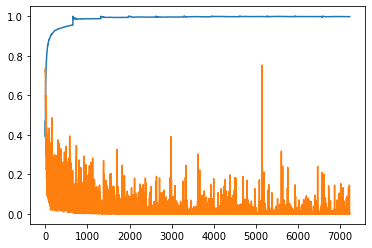

In [ ]:
# Plot accuracy and loss histories

plt.plot(history_accuracy)
plt.plot(history_loss)

In [ ]:
# Model evaluation 

model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
# Apply the same transformations on the test set as the training set so that the data distribution remains the same 

test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip()],0.7),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
# Define a function to predict an image

def predict_image(image):
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
# Predict accuracy of the test_set 

correct_counter=0
for i in range(len(validation_dataset)):
    image_tensor = validation_dataset[i][0].unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    if index == validation_dataset[i][1]:
        correct_counter+=1
print("Accuracy=",correct_counter/len(validation_dataset))

Accuracy= 0.9906684441058846


In [ ]:
# Create a data frame from the sample submission file

submission=pd.read_csv(BASE_PATH+'sample_submission.csv')

In [ ]:
# Check if the dataframe was created properly

submission.head(3)

,File,Label
0,90421068-27692.jpg,0
1,81279751-18187.jpg,0
2,106361457-9185.jpg,0


In [ ]:
# Create a new data frame with file name and label as column headers

submission_csv=pd.DataFrame(columns=['File','Label'])

In [ ]:
# Predict test set images and add the predictions to the submission_csv dataframe

IMG_TEST_PATH=os.path.join(BASE_PATH,'test/')
for i in range(len(submission)):
    img=Image.open(IMG_TEST_PATH+submission.iloc[i][0])
    prediction=predict_image(img)
    submission_csv=submission_csv.append({'File': submission.iloc[i][0],'Label': prediction},ignore_index=True)
    if(i%10==0 or i==len(submission)-1):
        print('[',32*'=','>] ',round((i+1)*100/len(submission),2),' % Complete')

[ ================================ >]  0.25  % Complete
[ ================================ >]  2.75  % Complete
[ ================================ >]  5.25  % Complete
[ ================================ >]  7.75  % Complete
[ ================================ >]  10.25  % Complete
[ ================================ >]  12.75  % Complete
[ ================================ >]  15.25  % Complete
[ ================================ >]  17.75  % Complete
[ ================================ >]  20.25  % Complete
[ ================================ >]  22.75  % Complete
[ ================================ >]  25.25  % Complete
[ ================================ >]  27.75  % Complete
[ ================================ >]  30.25  % Complete
[ ================================ >]  32.75  % Complete
[ ================================ >]  35.25  % Complete
[ ================================ >]  37.75  % Complete
[ ================================ >]  40.25  % Complete
[ ================================ 

In [ ]:
# Write the submision_csv dataframe to a csv file

submission_csv.to_csv('submission_epoch11_2.csv',index=False)